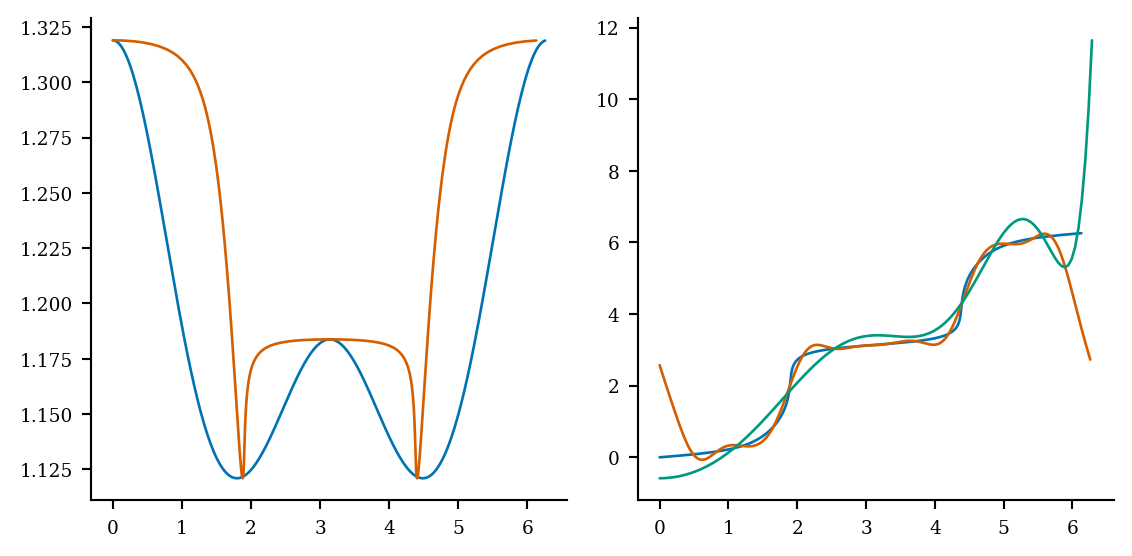

In [40]:
import desc.examples
from desc.plotting import plot_3d, plot_boundary
from desc.grid import LinearGrid, Grid
from desc.basis import DoubleFourierSeries, ChebyshevPolynomial, PowerSeries
from desc.transform import Transform
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

eq = desc.examples.get("precise_QA")
surface = eq.surface
axis = eq.get_axis()

M=128
N=8

grid = LinearGrid(M=M, N=N, NFP=2)

surface_data = surface.compute(["R", "Z"], grid=grid)
surface_data = np.c_[surface_data["R"], surface_data["Z"]]

axis_data = axis.compute(["R", "Z"], grid=grid)
axis_data = np.c_[axis_data["R"], axis_data["Z"]]

minor_vectors = surface_data - axis_data
theta = (np.arctan2(minor_vectors[:,1], -minor_vectors[:,0]) + np.pi) % (2.0 * np.pi)

sample_points = grid.nodes.reshape(N*2+1, M*2+1, 3)


theta_basis = DoubleFourierSeries(M=10, N=4, NFP=2, sym=False)
theta_transform = Transform(
    Grid(
        np.c_[np.ones_like(theta), theta, grid.nodes[:,2]], 
        sort=False, 
        jitable=True
    ), 
    theta_basis, 
    build=False, 
    build_pinv=True
)
Tb_lmn = theta_transform.fit(grid.nodes[:,1])

transformed_theta = Transform(
    grid, 
    theta_basis, 
    build=True,
).transform(Tb_lmn, 0, 0, 0)

grid2 = LinearGrid(L=M)
theta_basis2 = PowerSeries(12)
theta_transform2 = Transform(
    Grid(
        np.c_[theta[:M*2+1] / 2.0 / np.pi, np.zeros(M*2+1), np.zeros(M*2+1)], 
        sort=False, 
        jitable=True
    ), 
    theta_basis2, 
    build=False, 
    build_pinv=True
)
Tb_lmn2 = theta_transform2.fit(grid.nodes[:M*2+1,1] / 2.0 / np.pi)
transformed_theta2 = Transform(
    grid2, 
    theta_basis2, 
    build=True,
).transform(Tb_lmn2, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
ax1.plot(sample_points[0,:M*2+1,1], surface_data[:M*2+1,0])
ax1.plot(theta[:M*2+1], surface_data[:M*2+1,0])
ax2.plot(theta[:M*2+1], sample_points[0,:M*2+1,1])
ax2.plot(sample_points[0,:M*2+1,1], transformed_theta[:M*2+1])
ax2.plot(grid2.nodes[:,0] * 2.0 * np.pi, transformed_theta2 * 2.0 * np.pi)
plt.show()

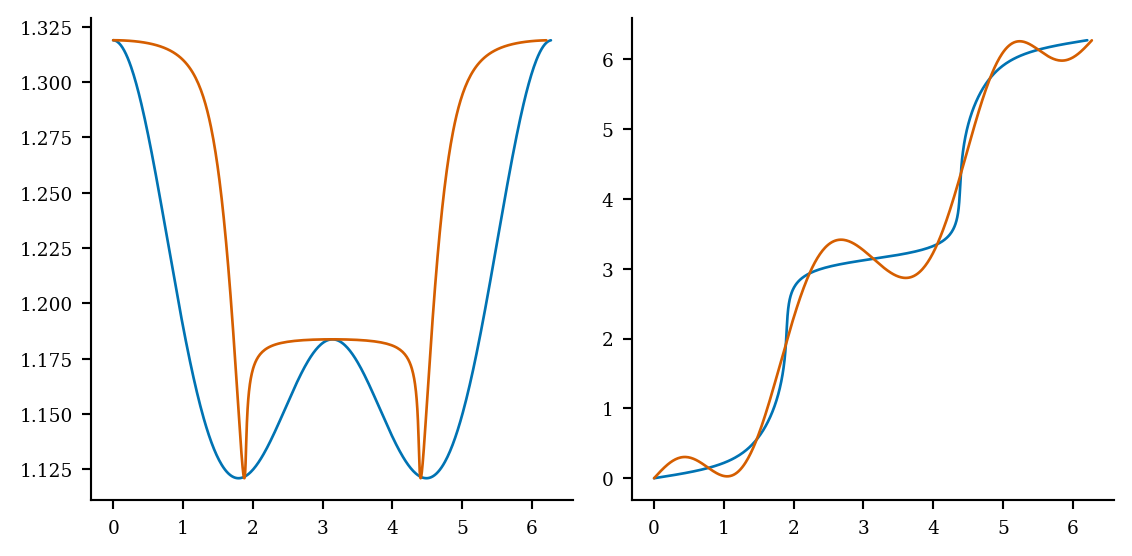

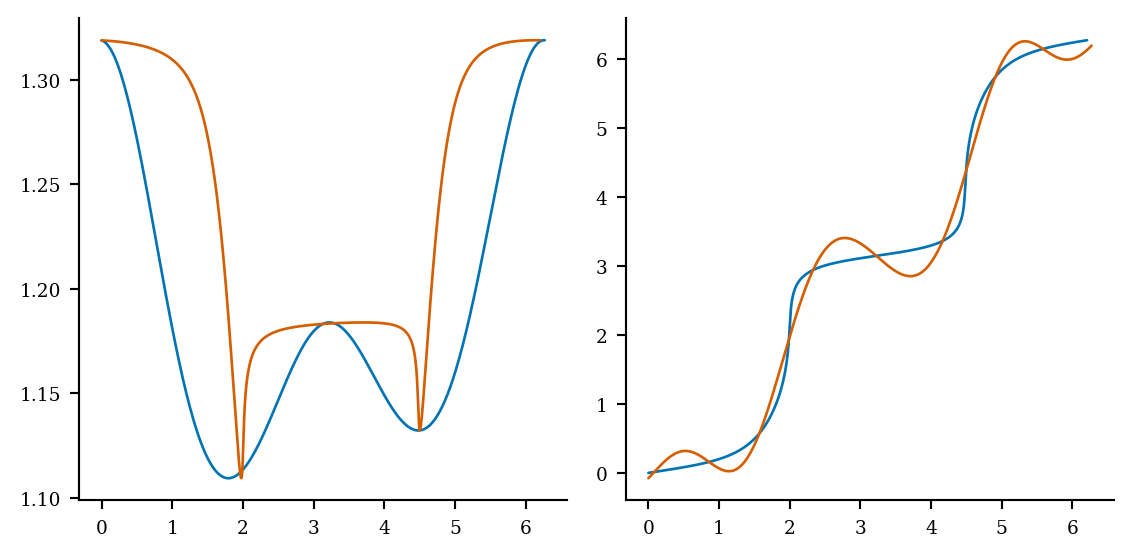

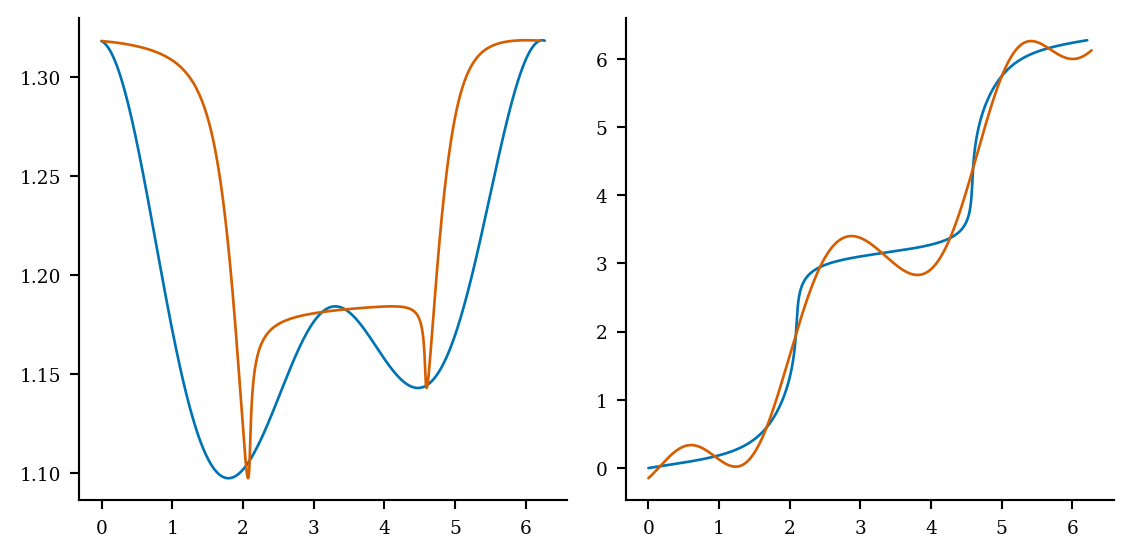

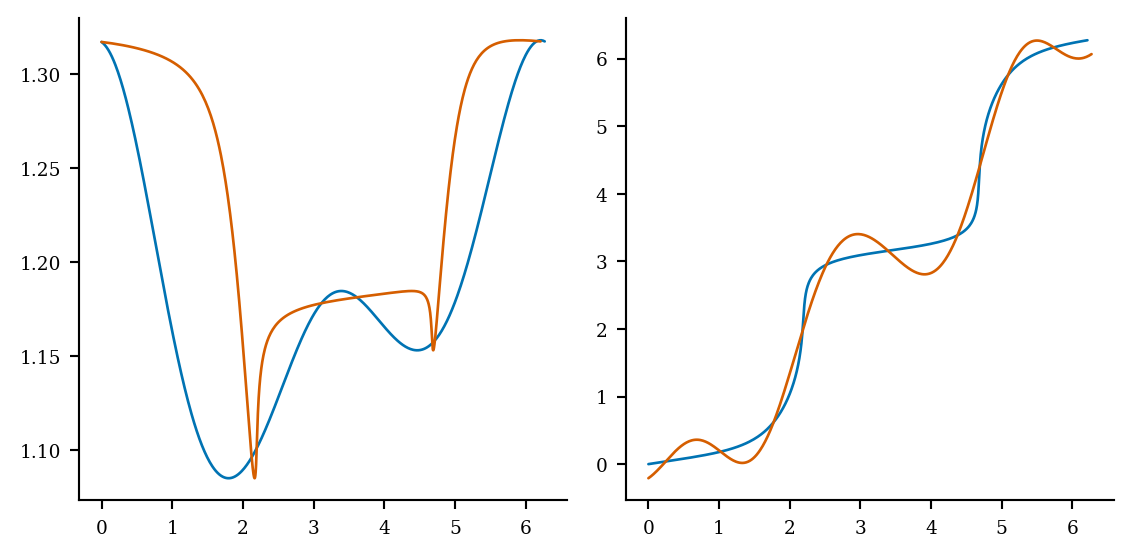

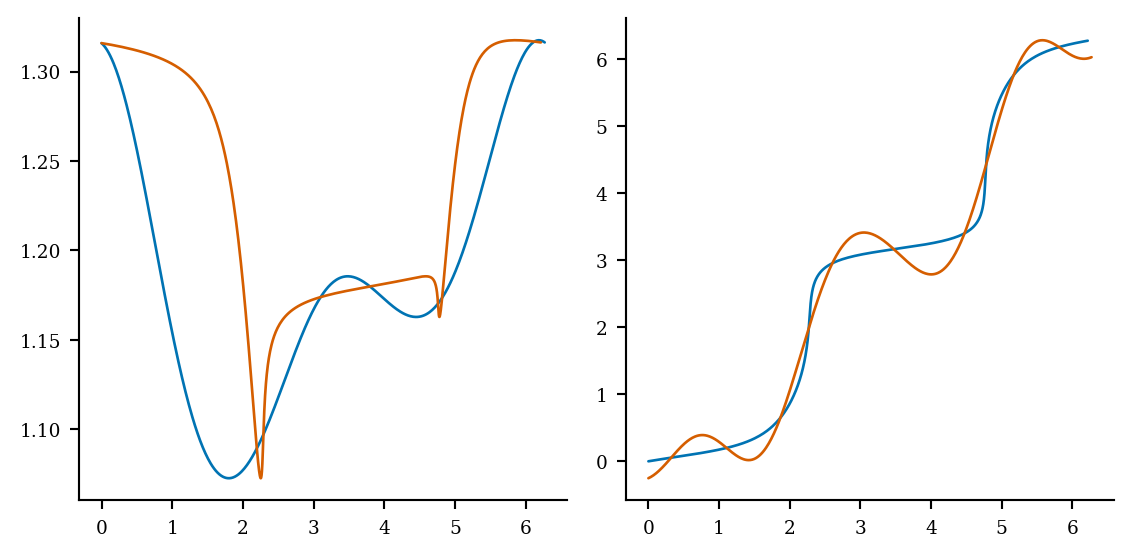

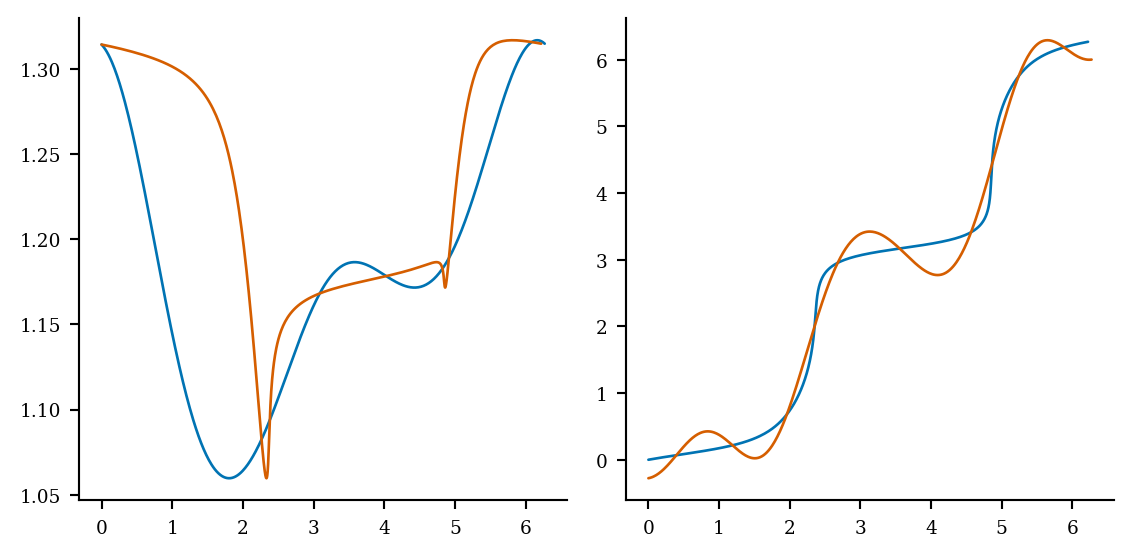

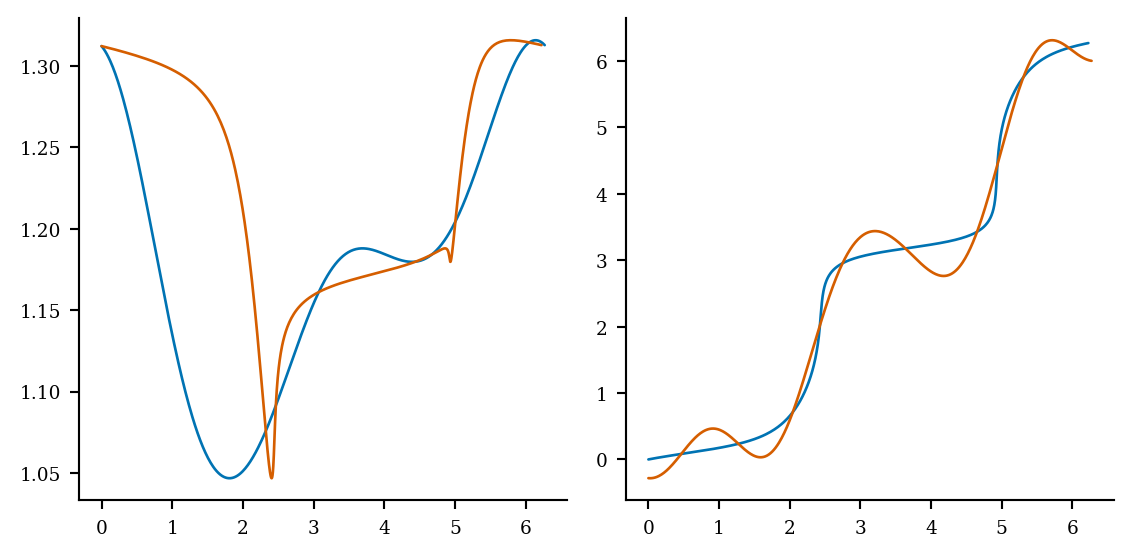

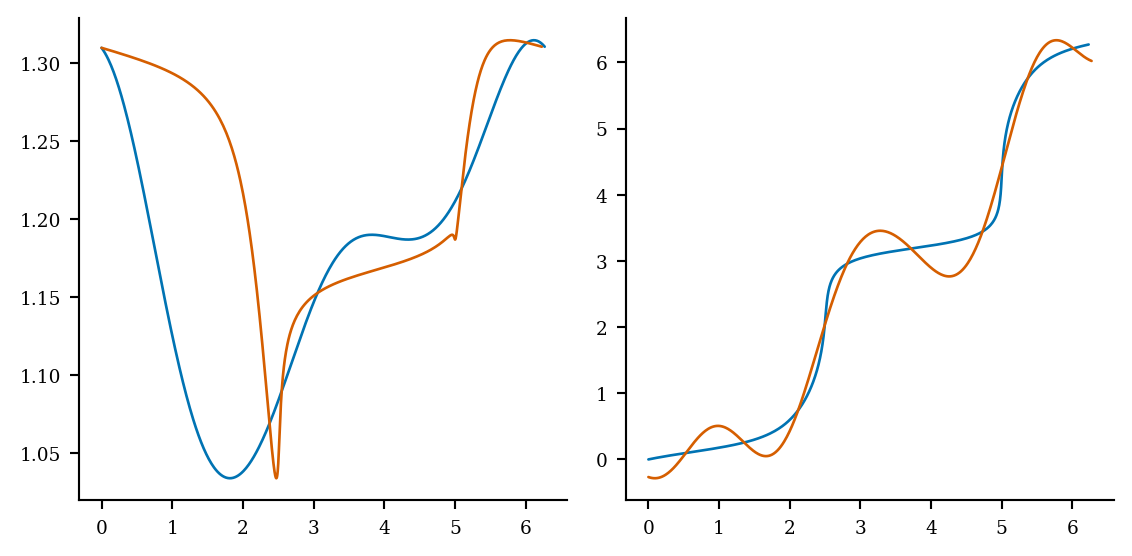

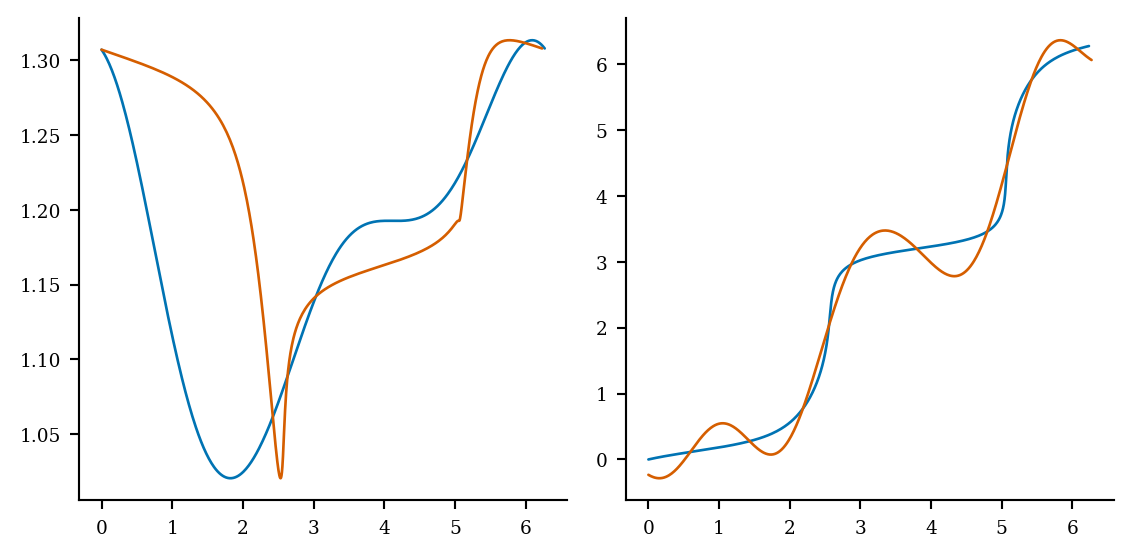

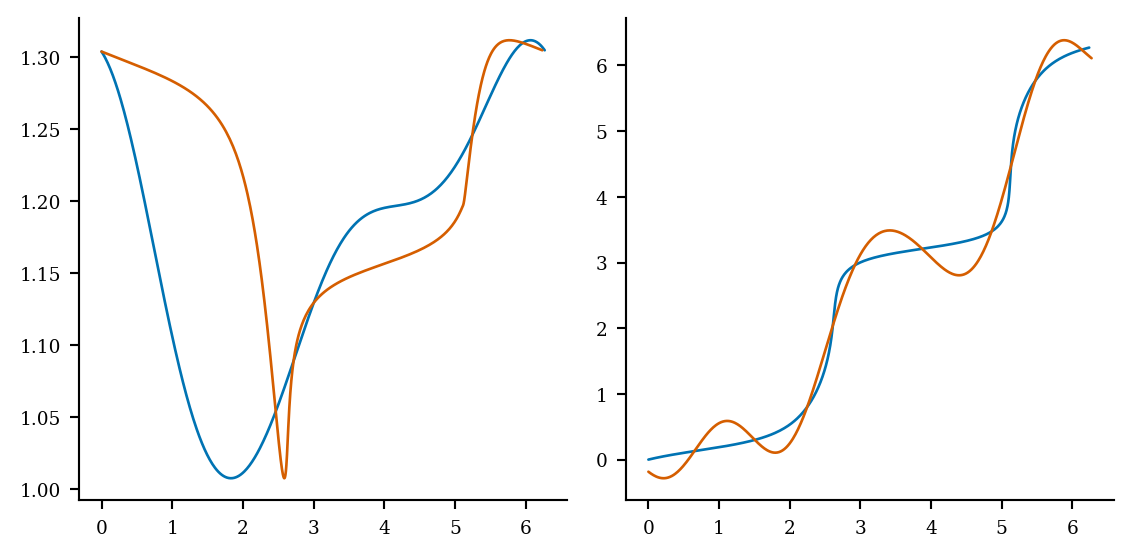

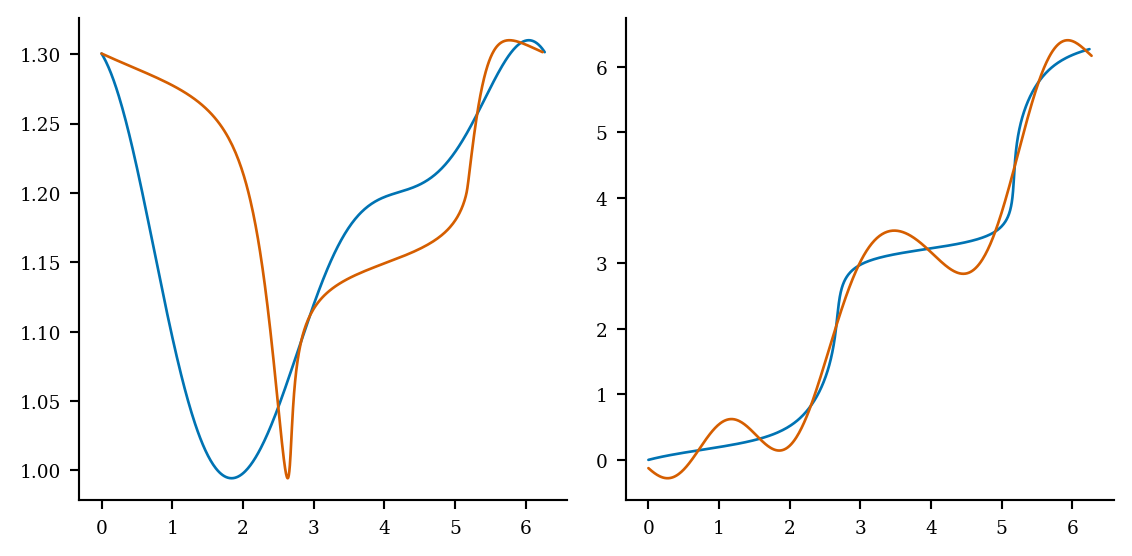

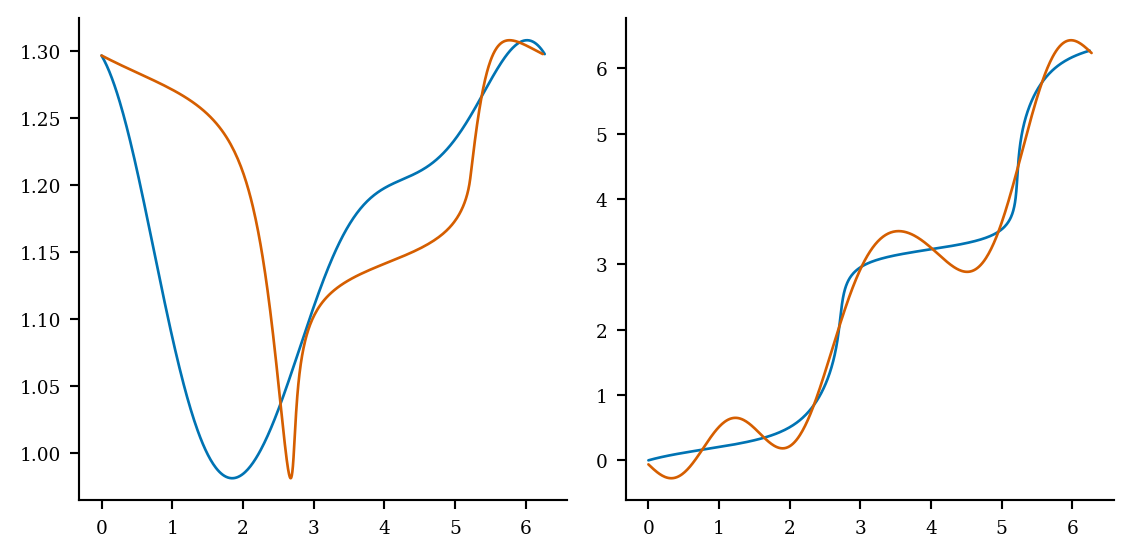

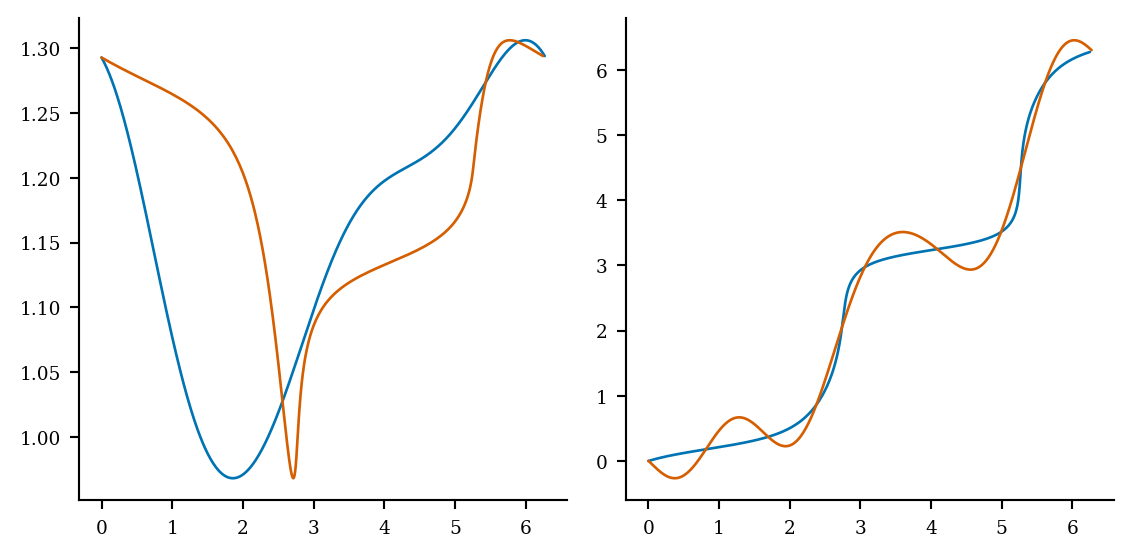

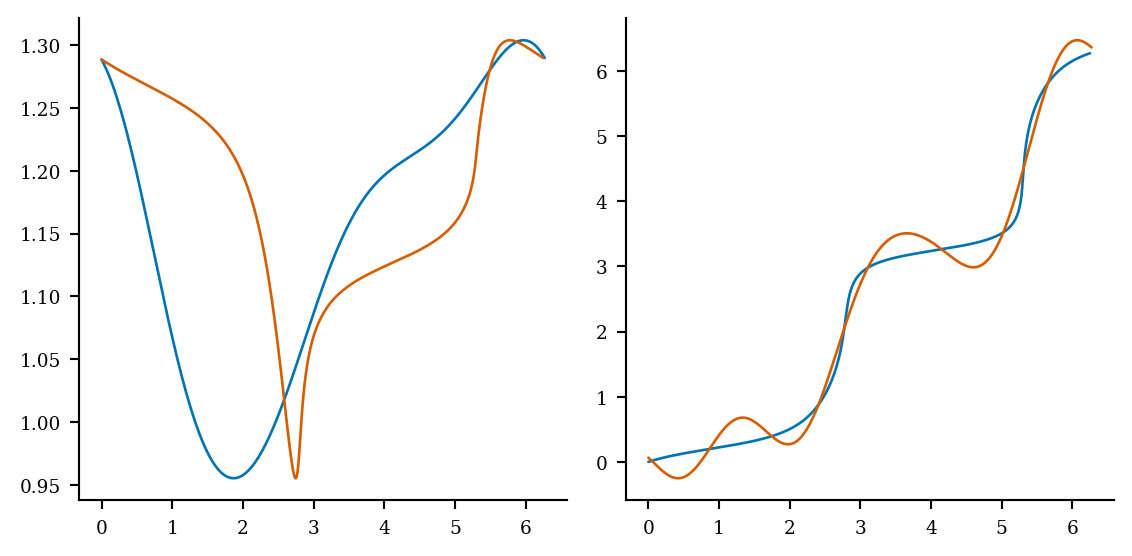

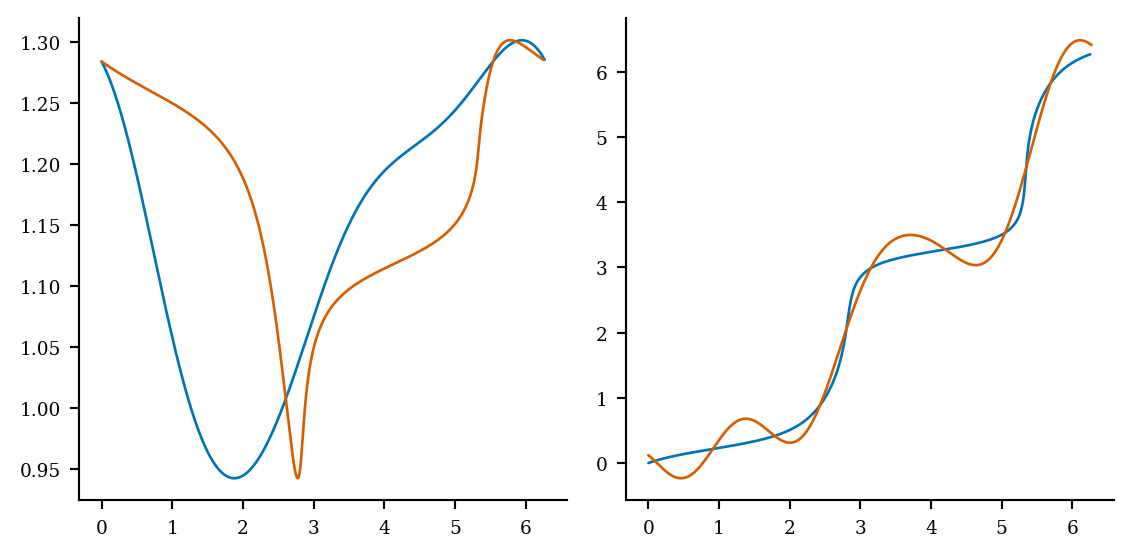

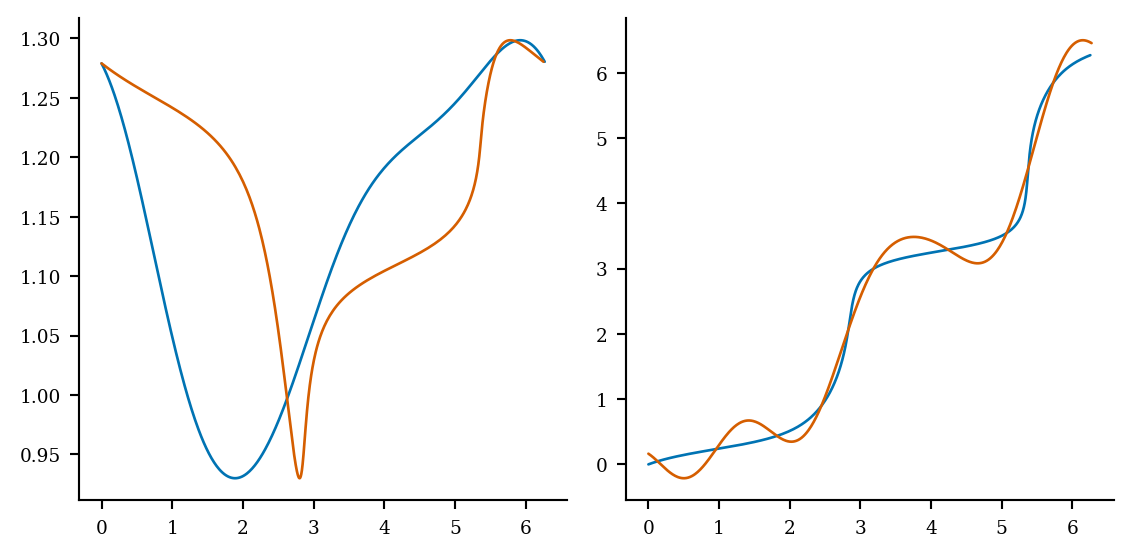

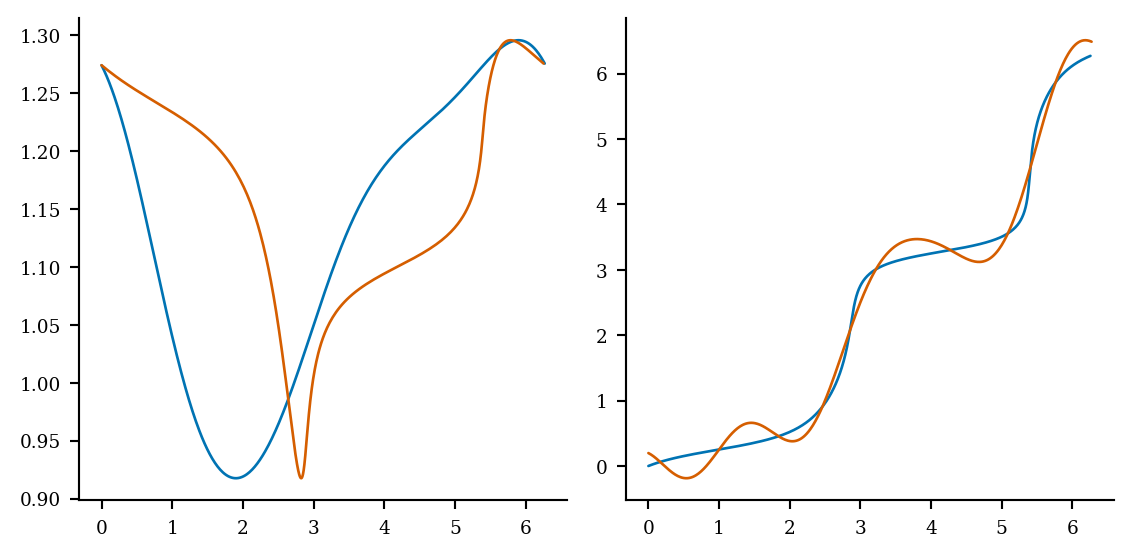

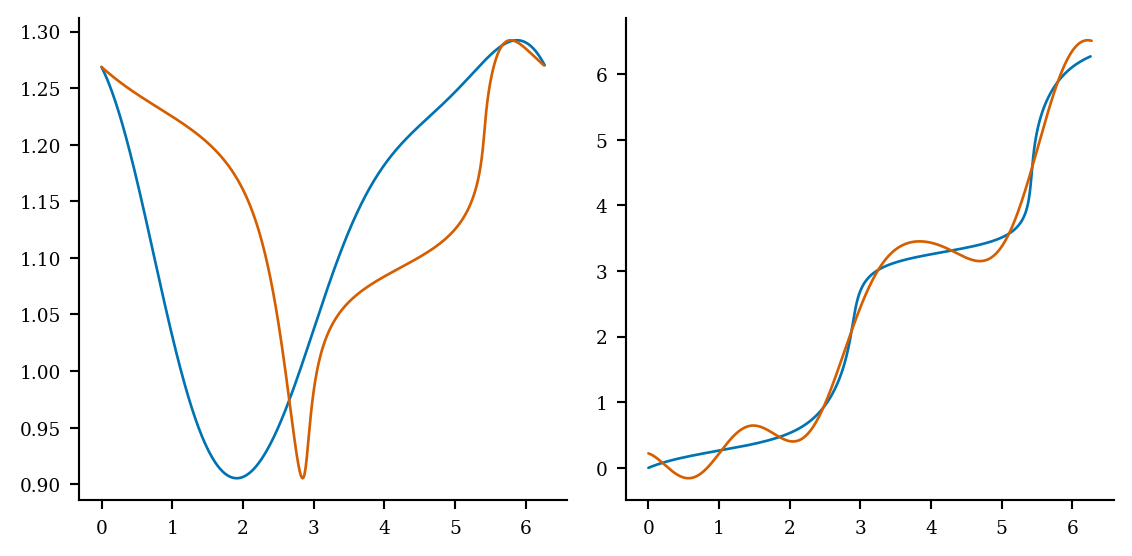

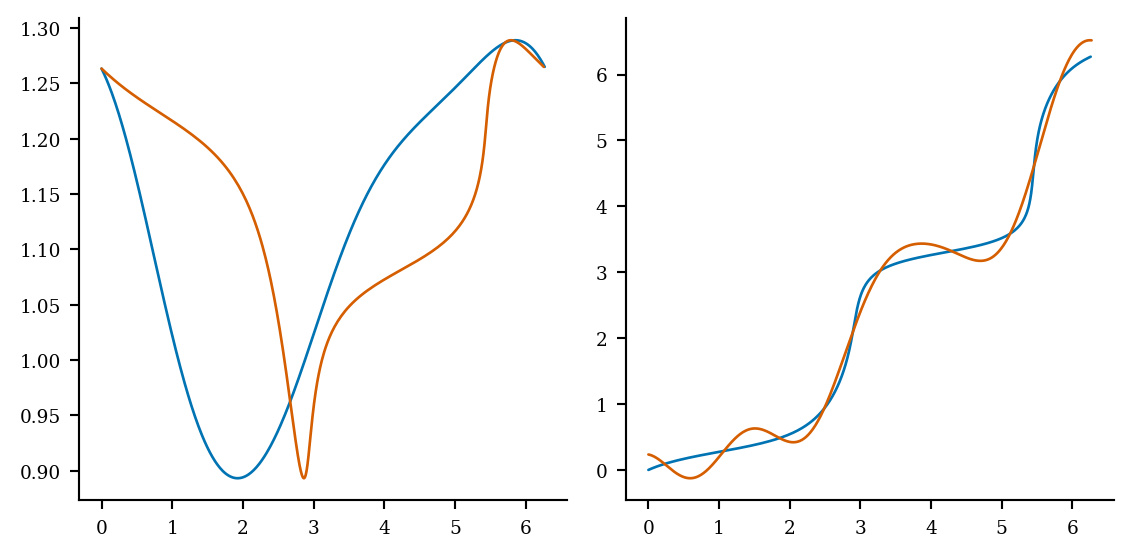

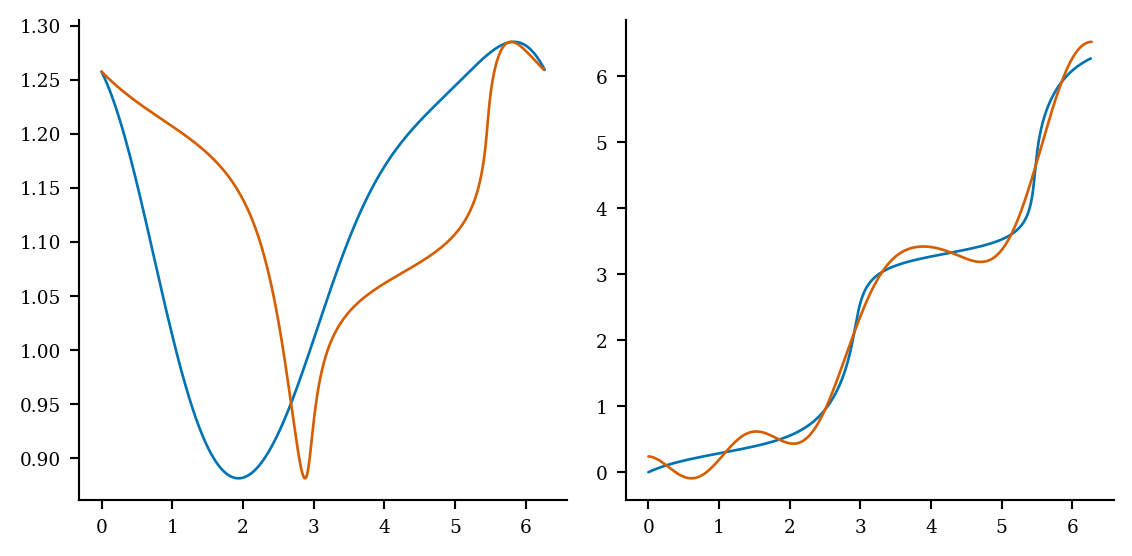

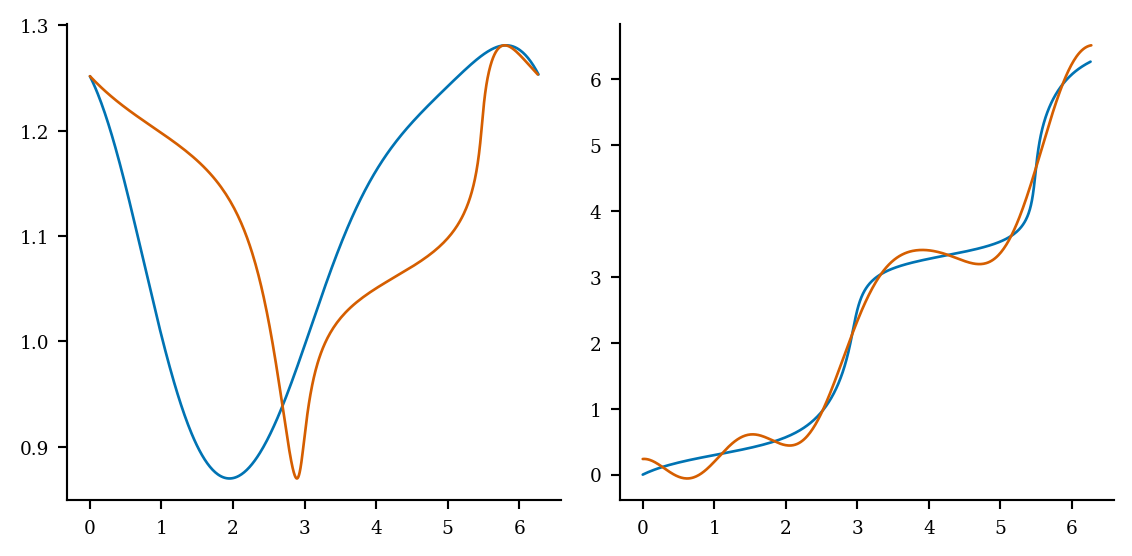

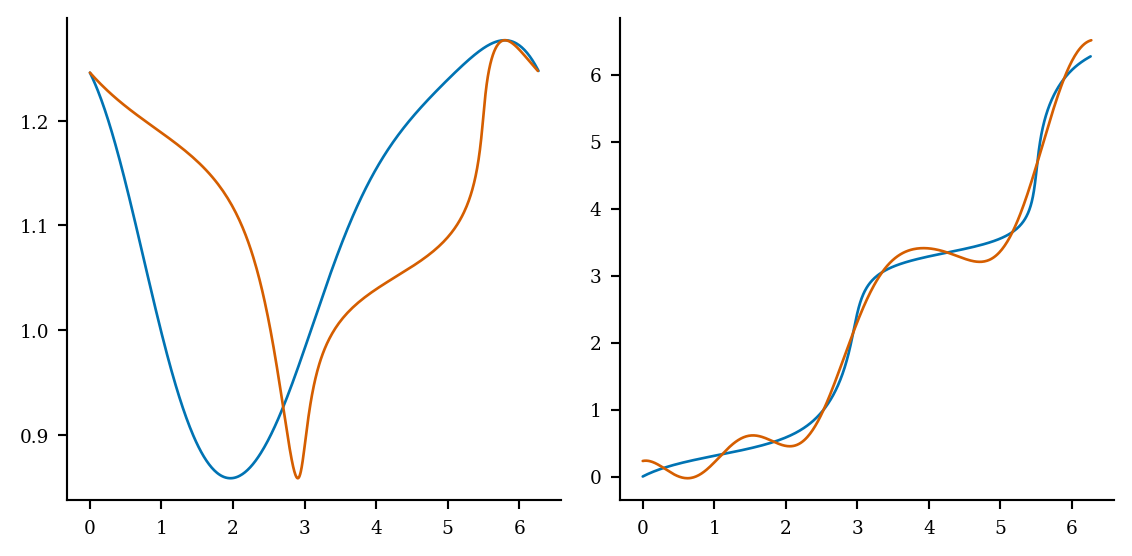

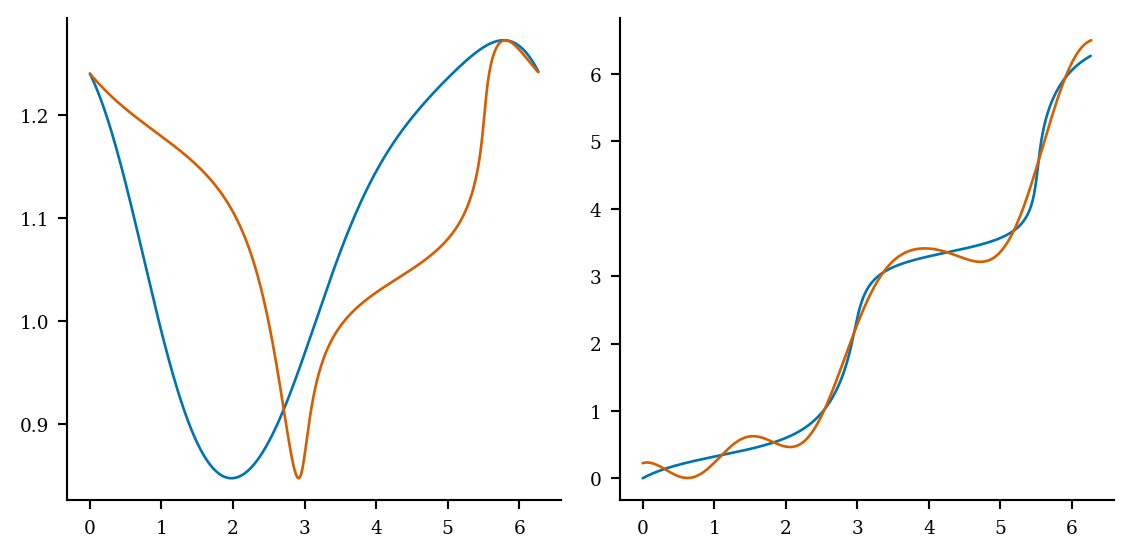

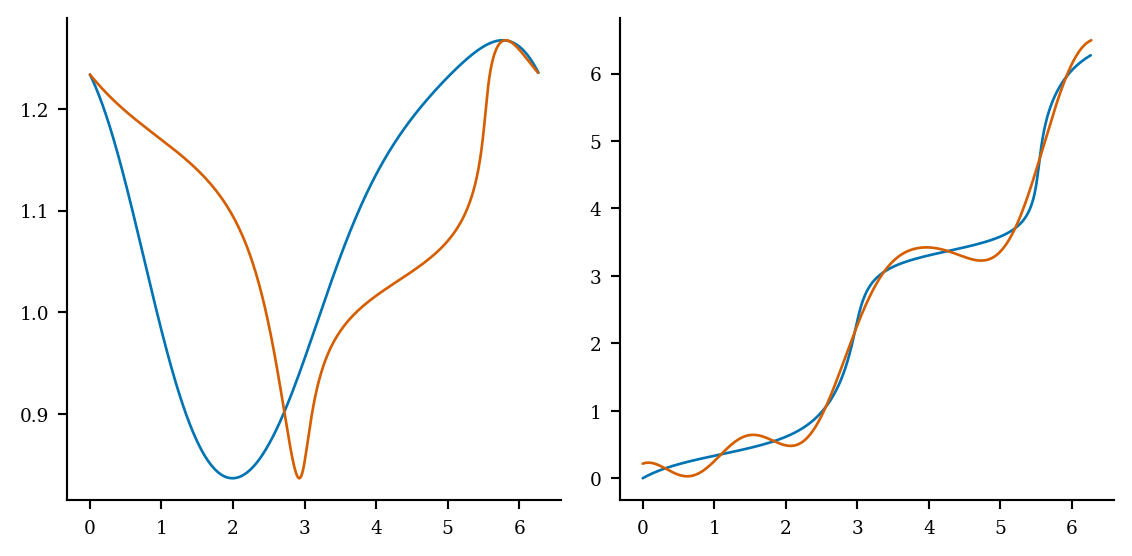

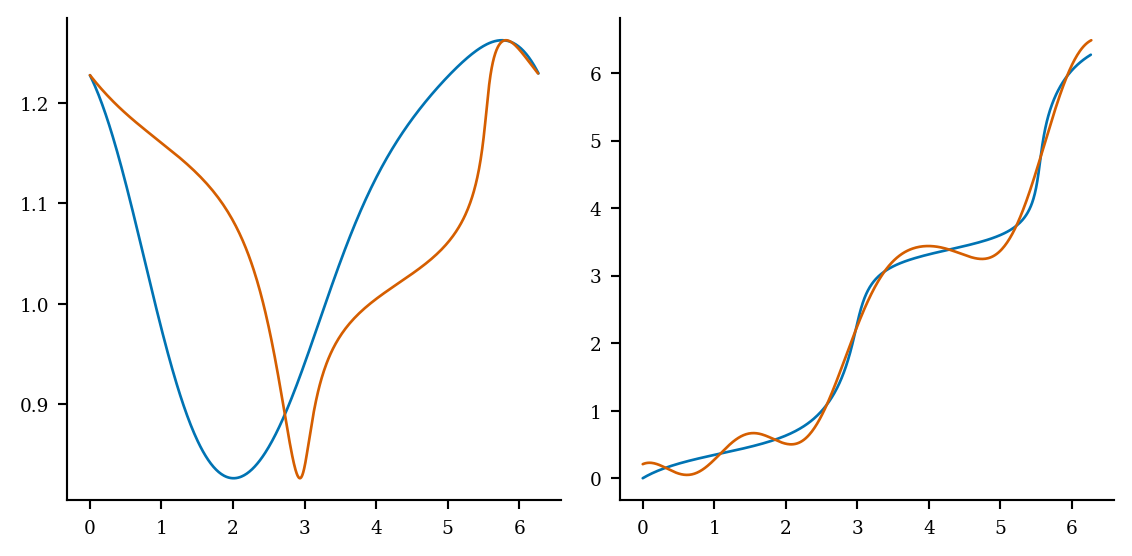

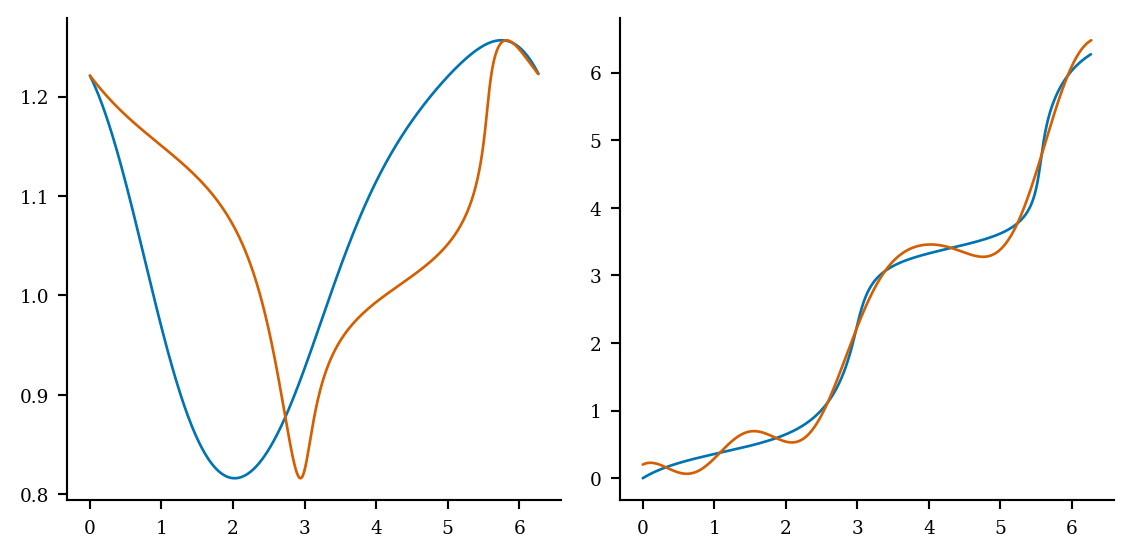

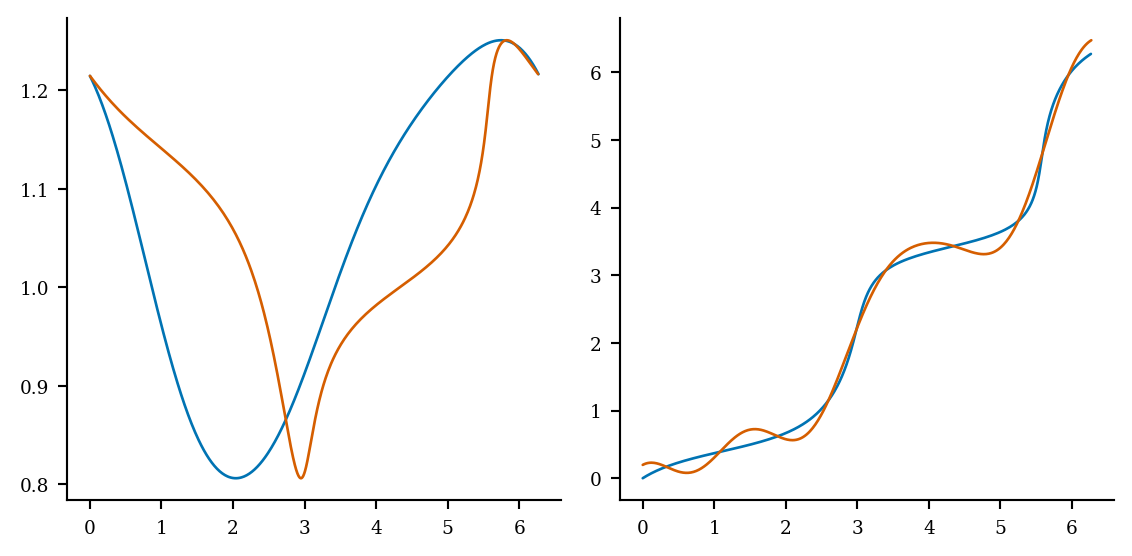

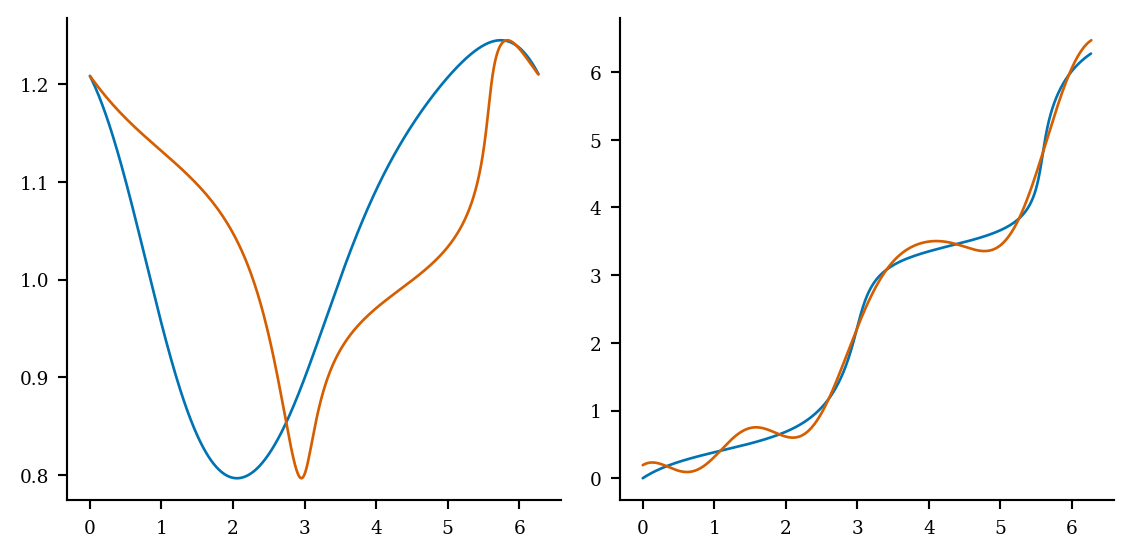

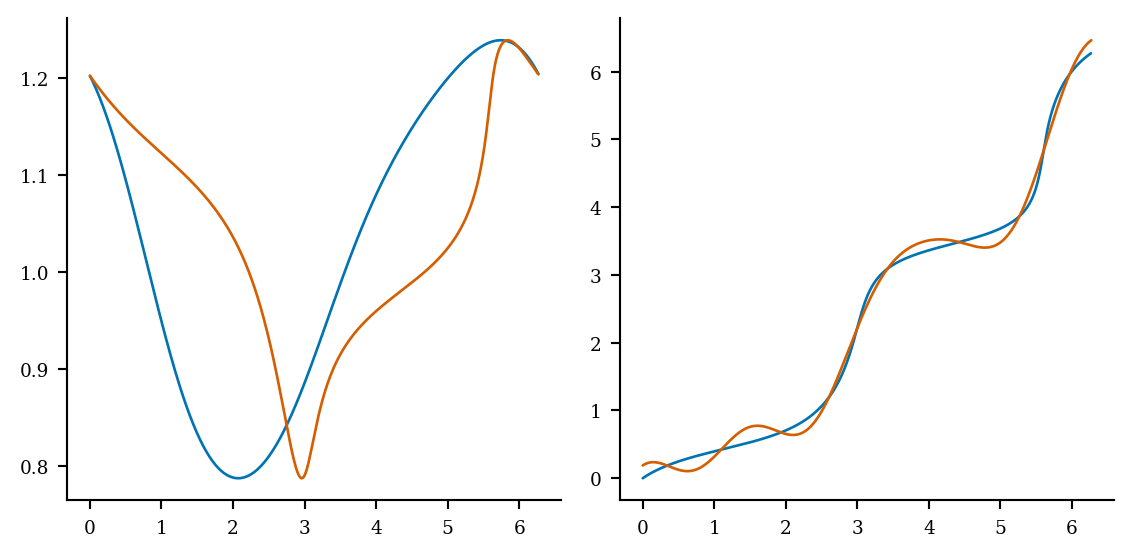

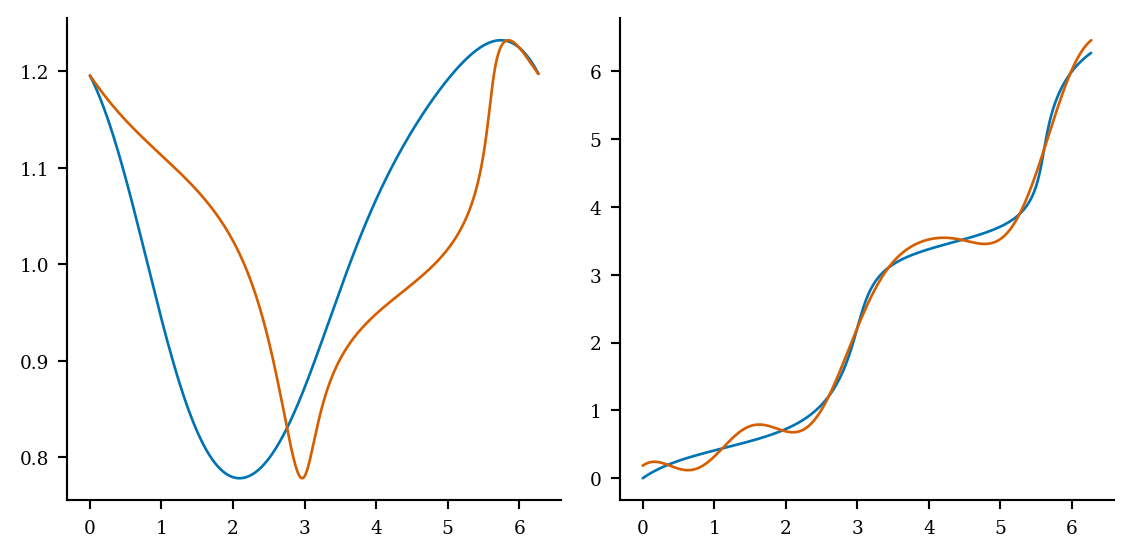

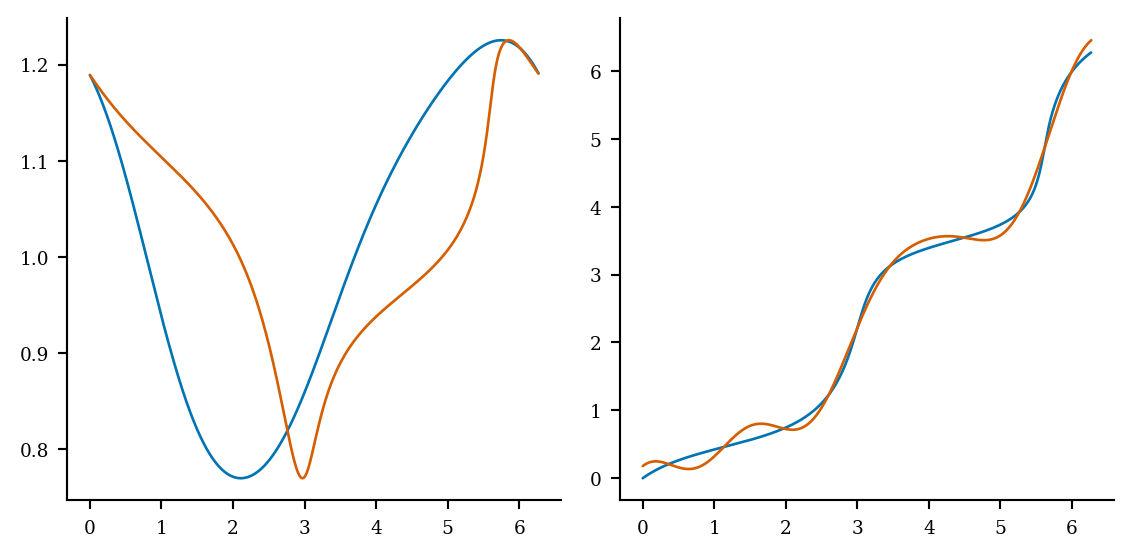

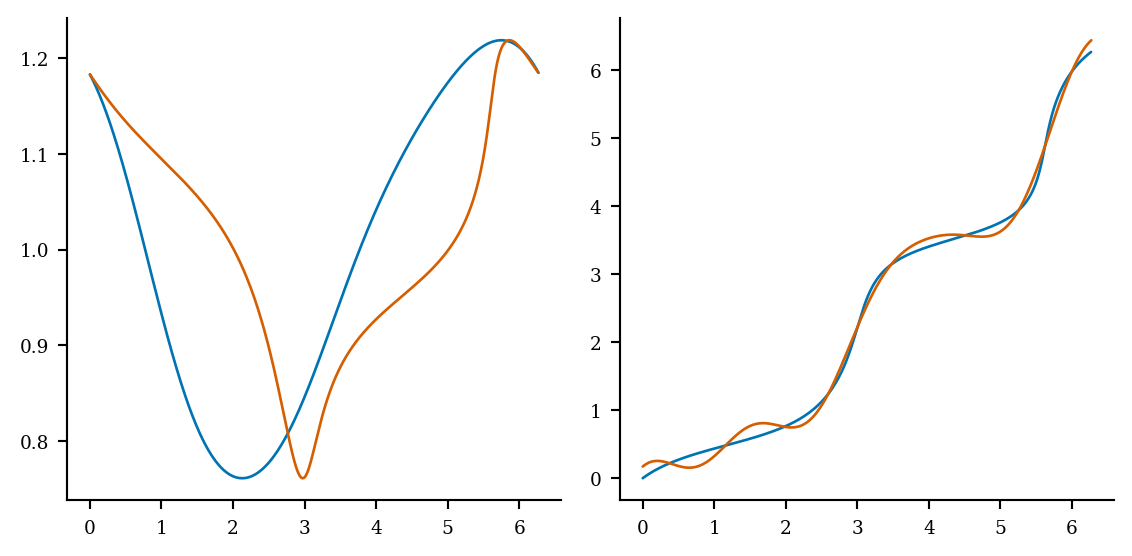

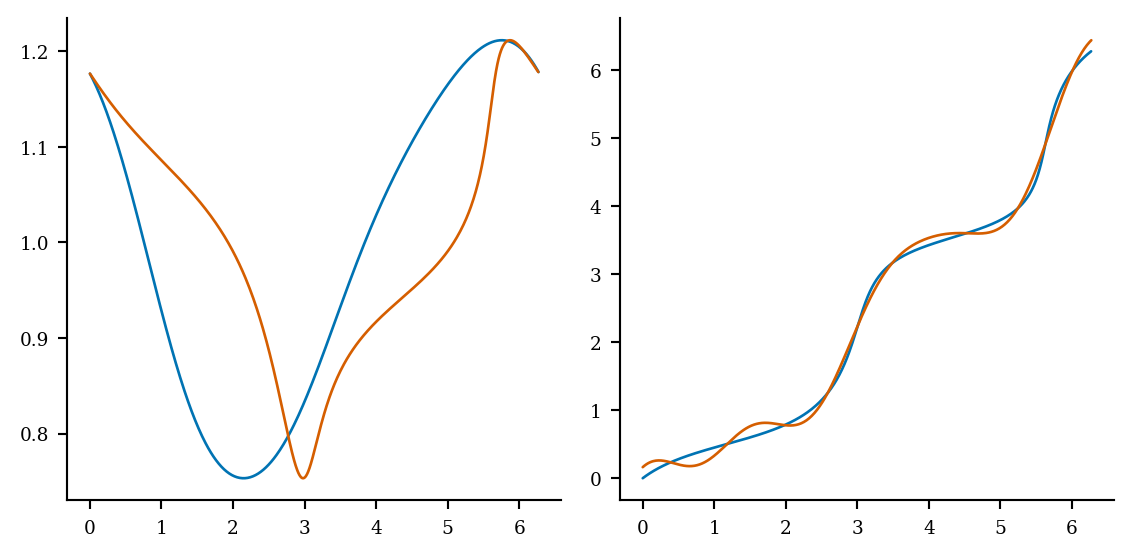

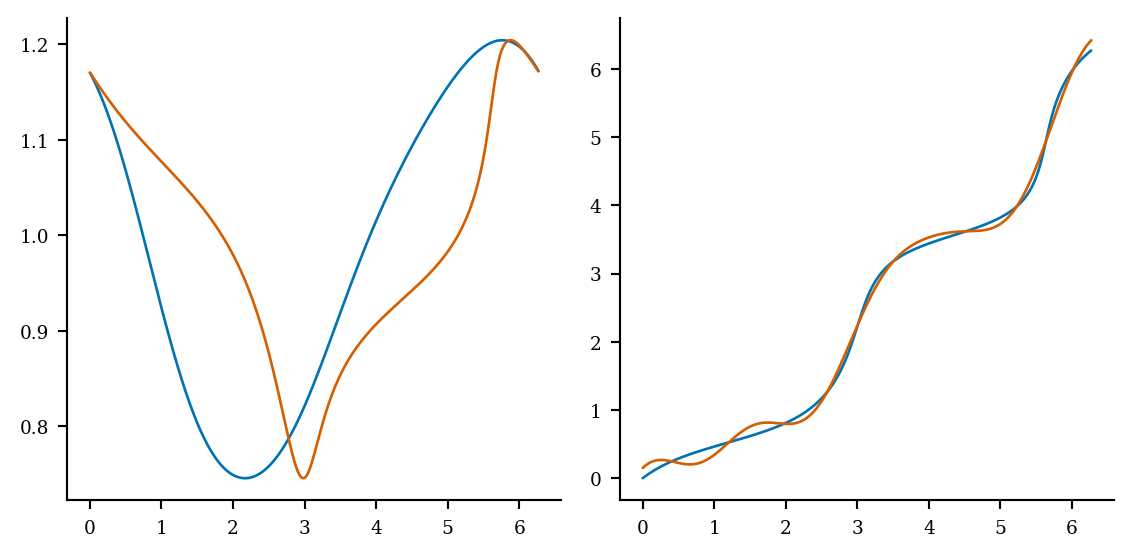

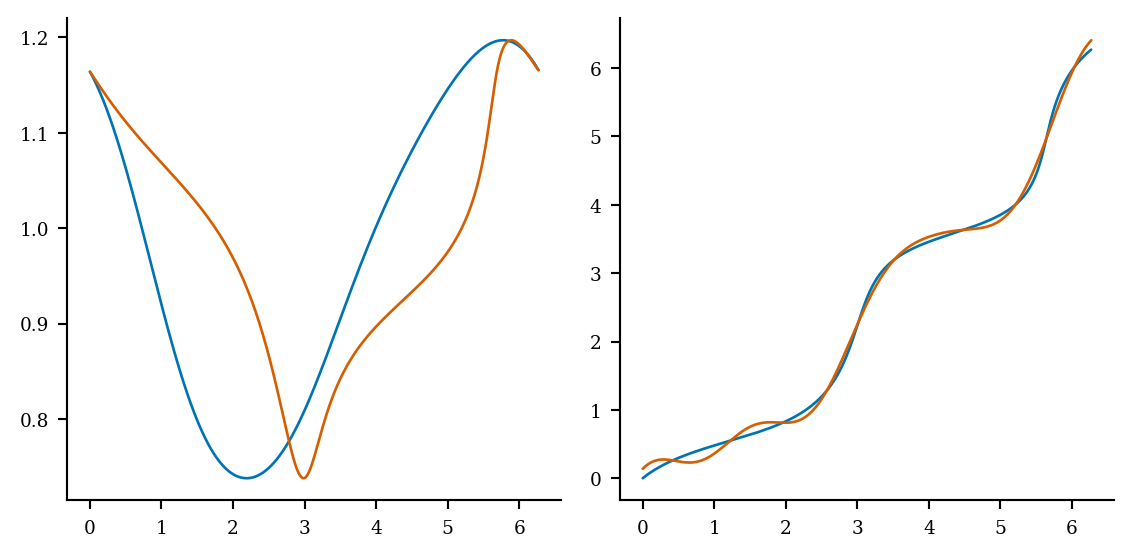

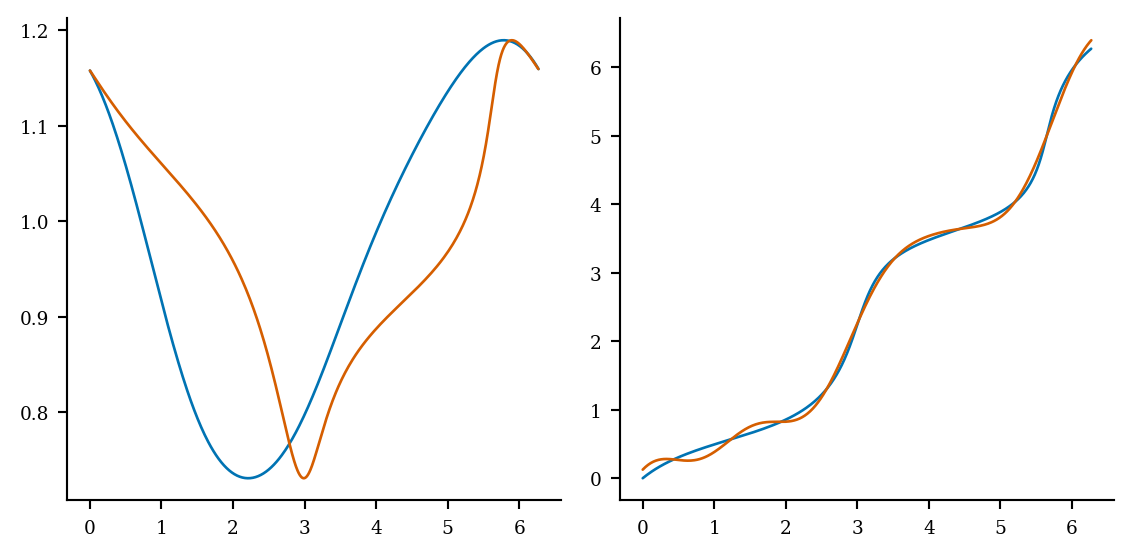

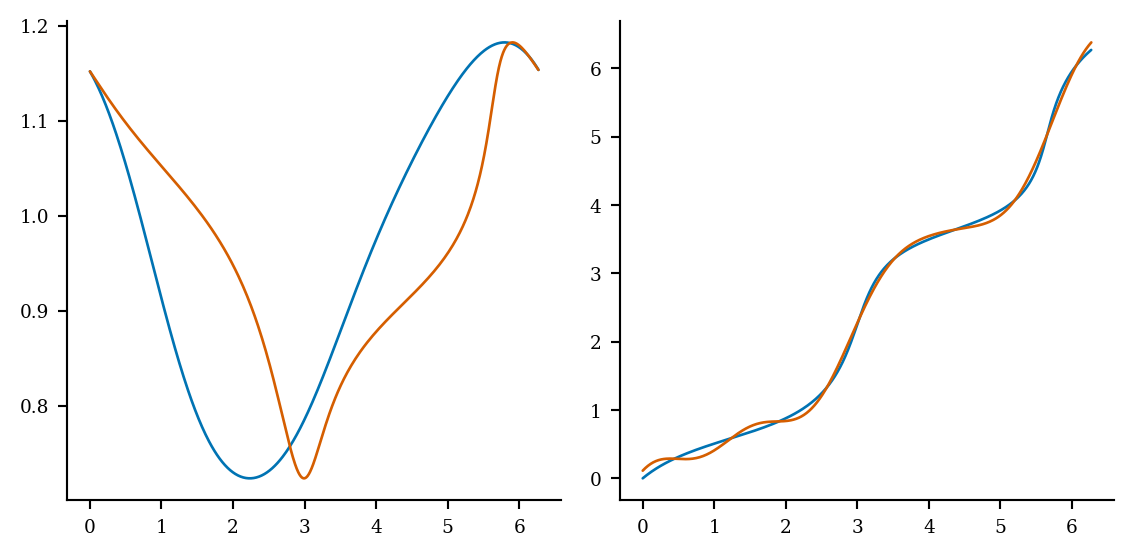

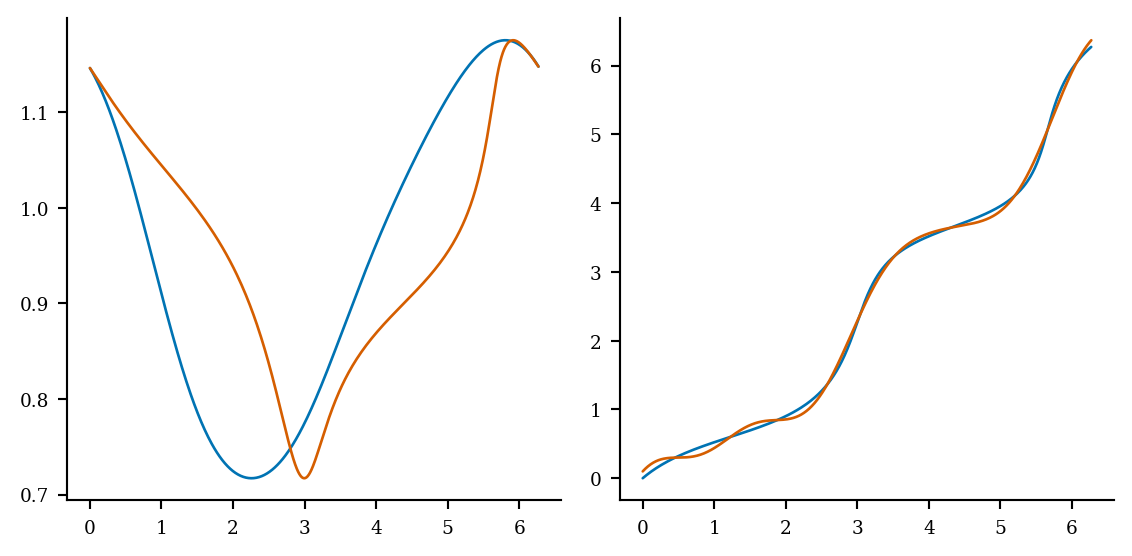

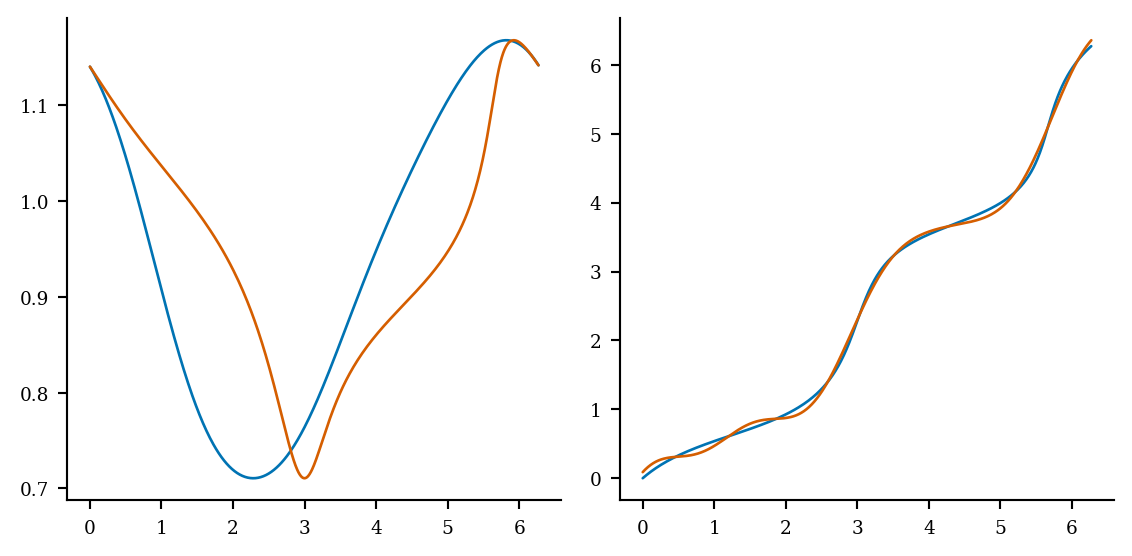

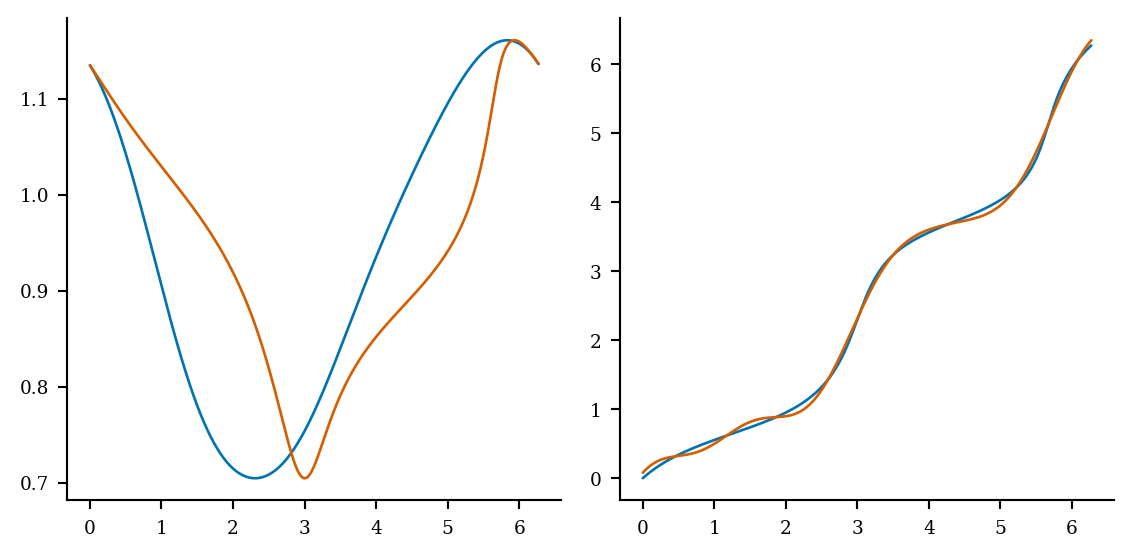

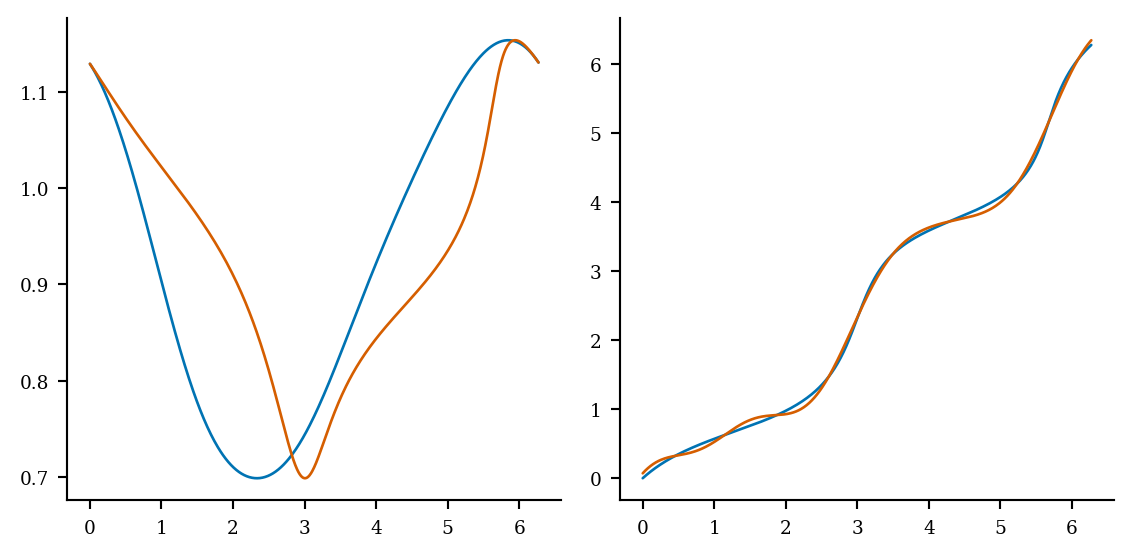

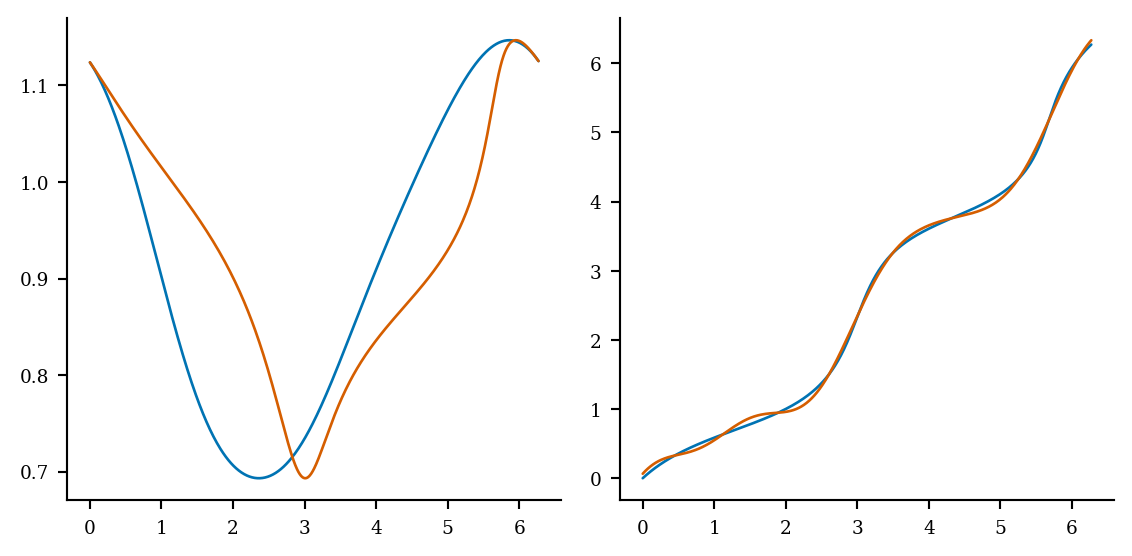

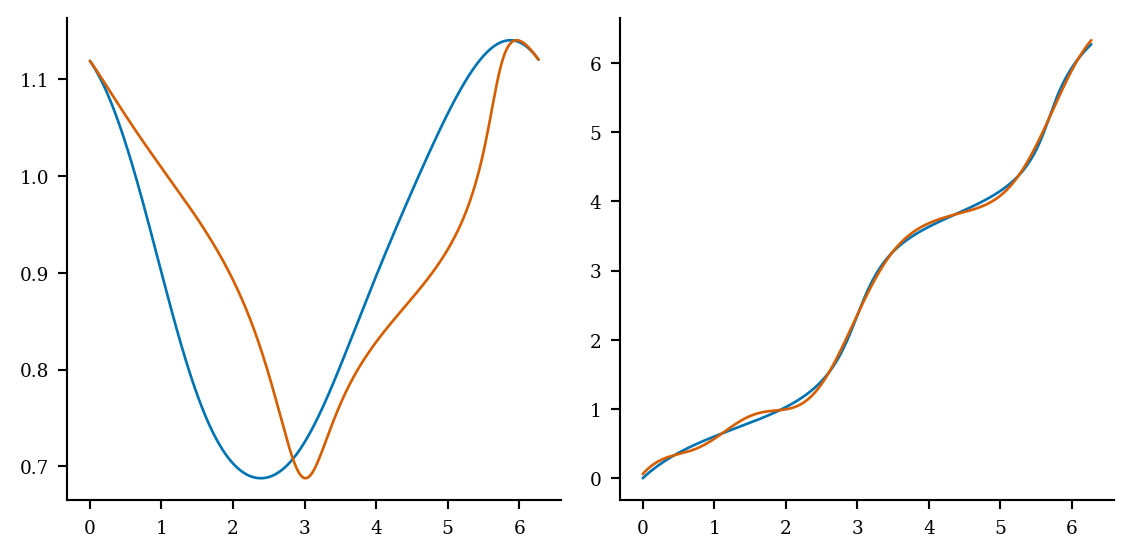

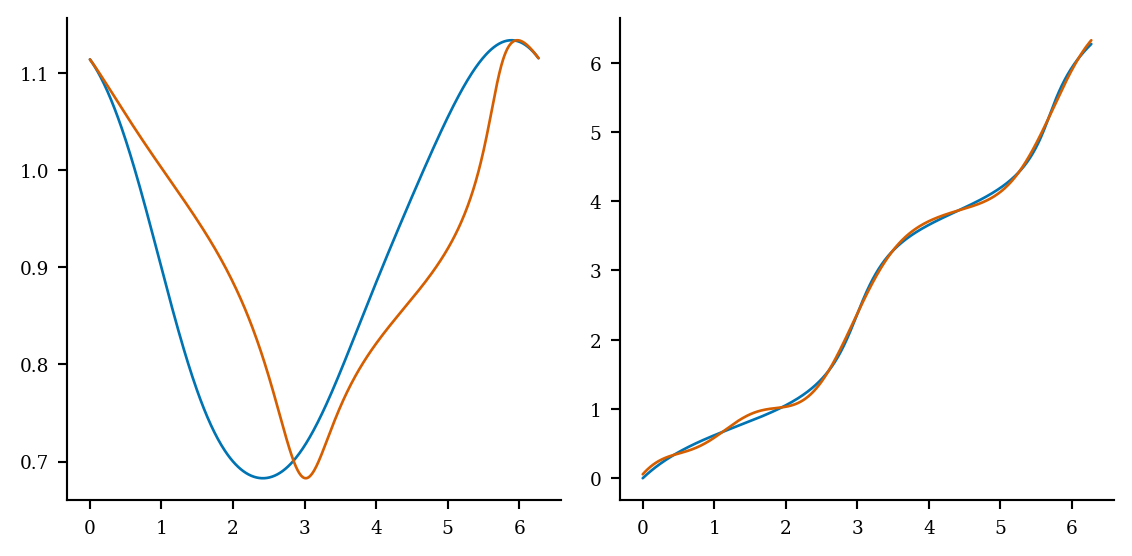

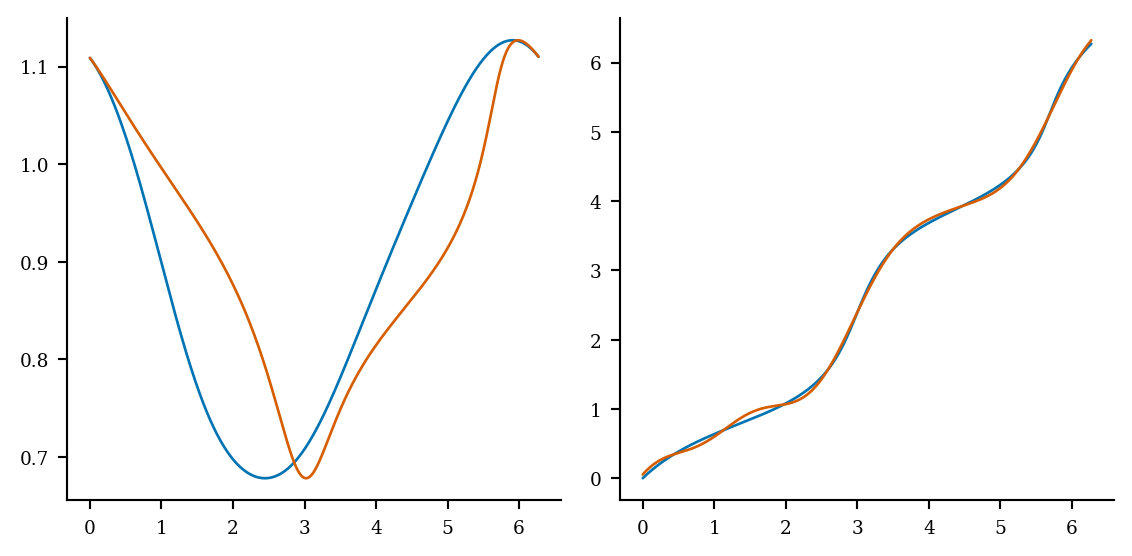

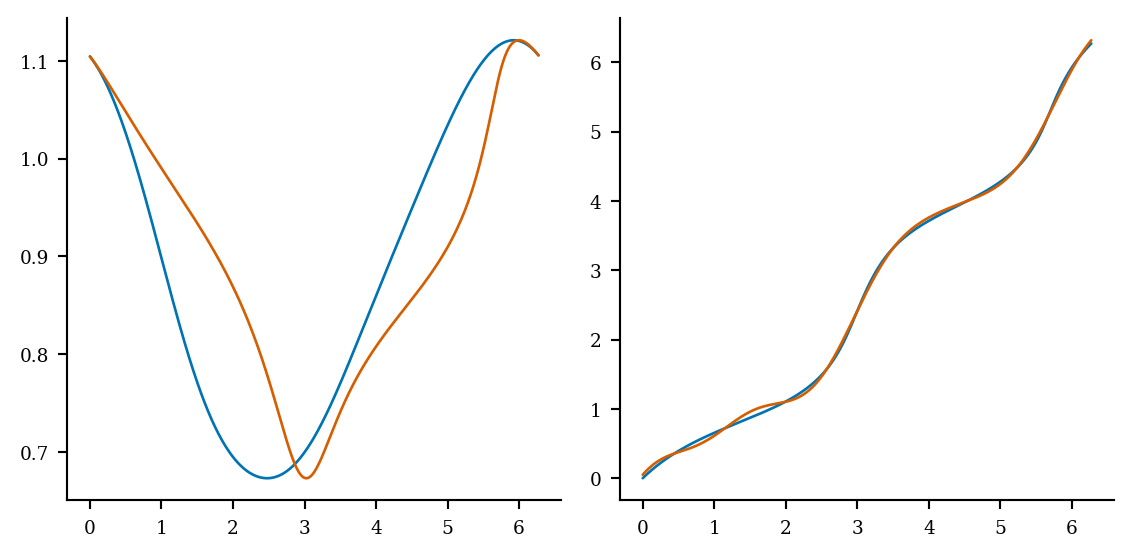

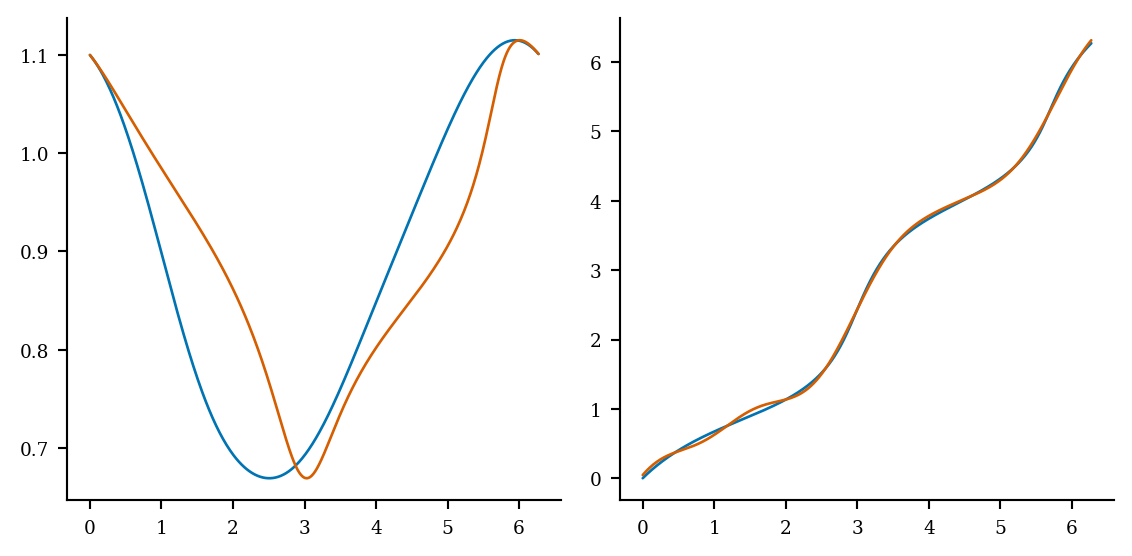

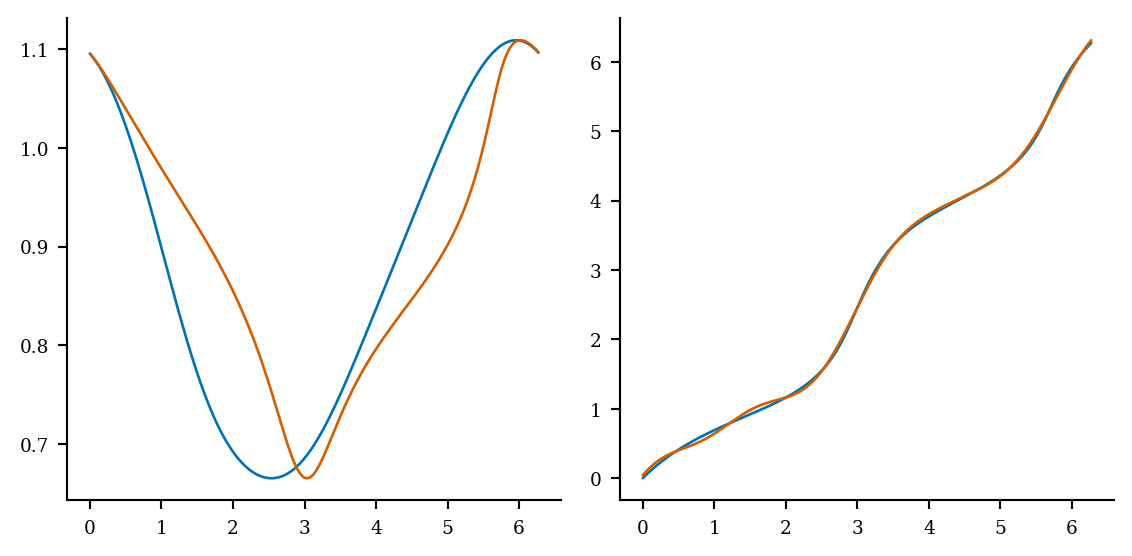

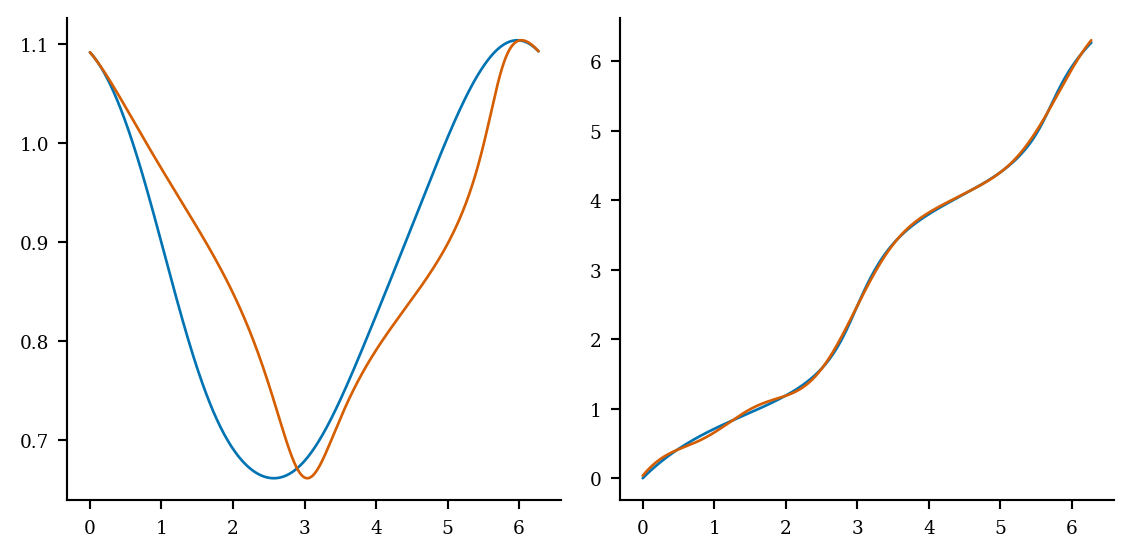

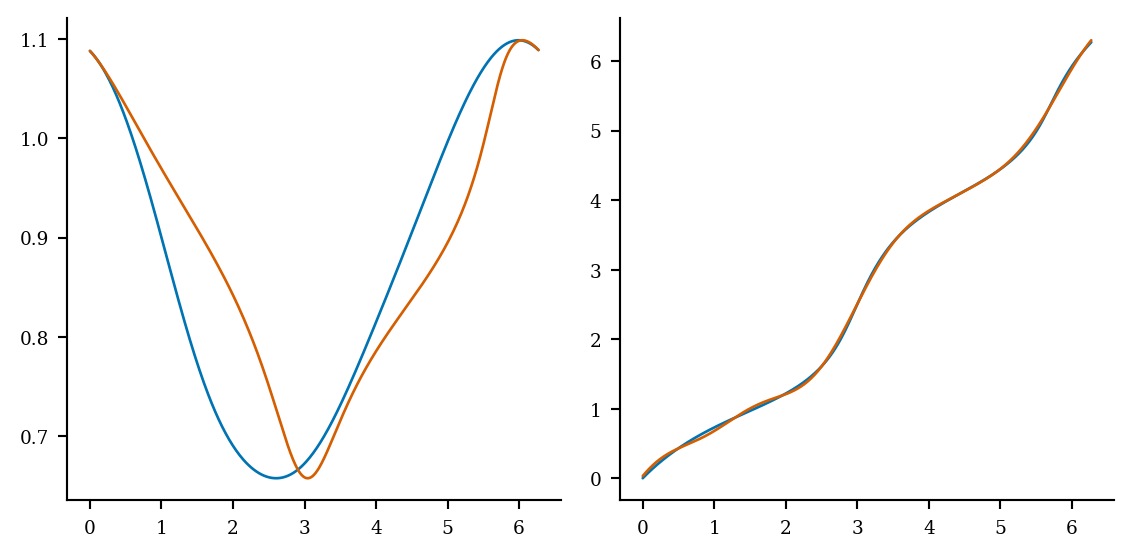

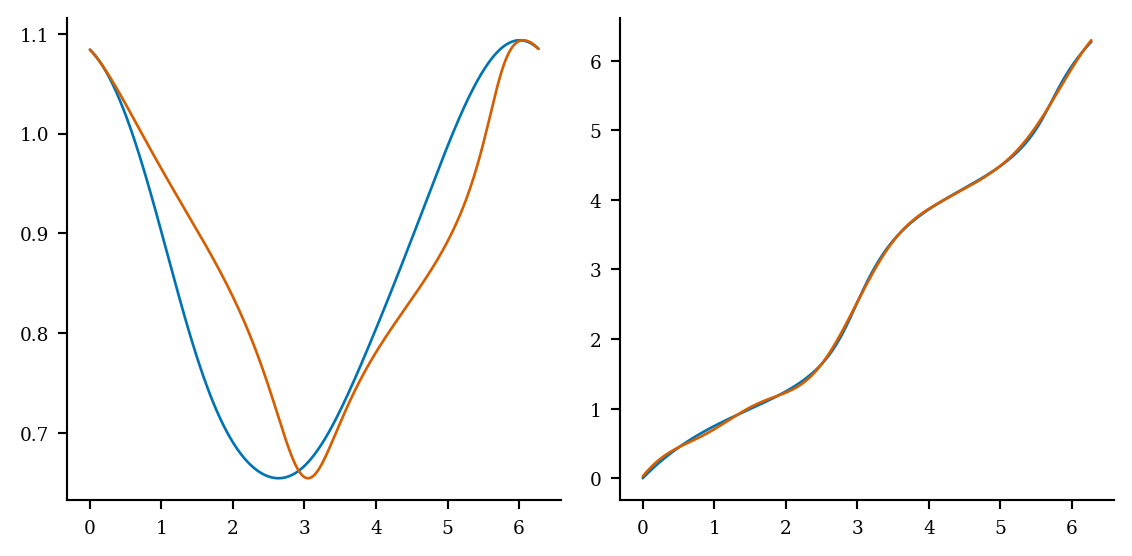

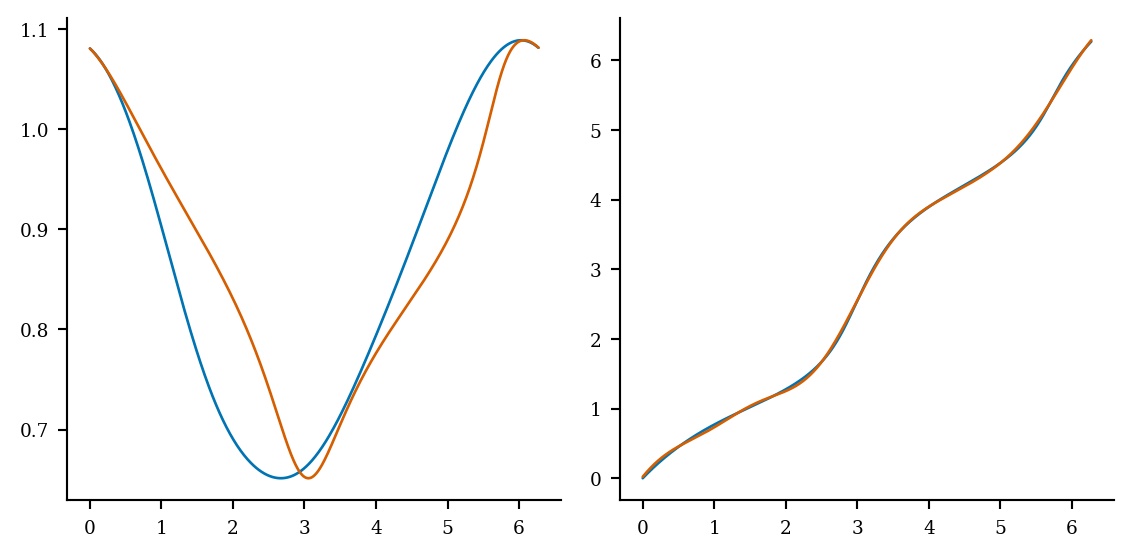

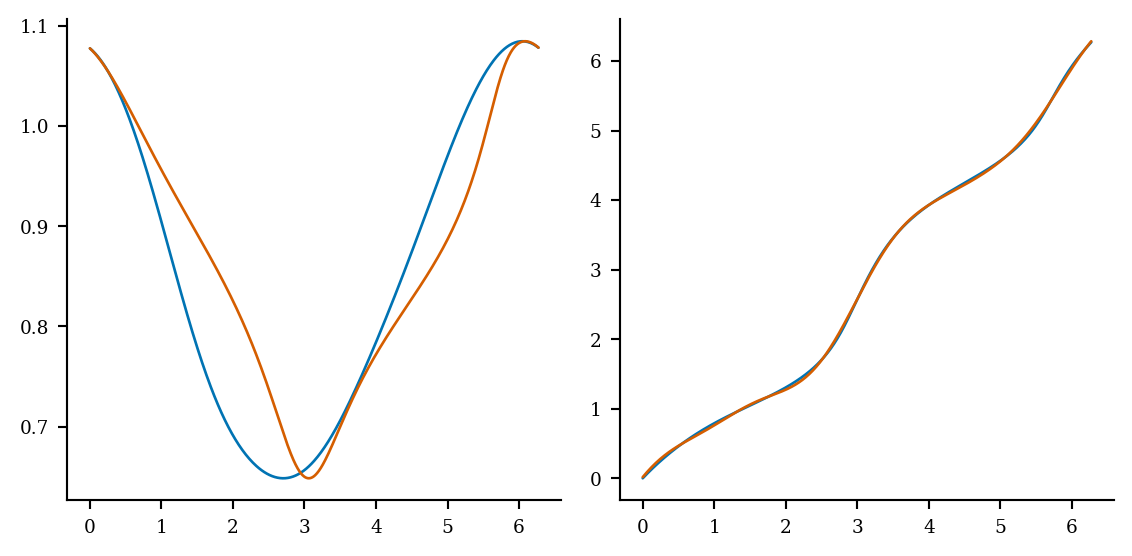

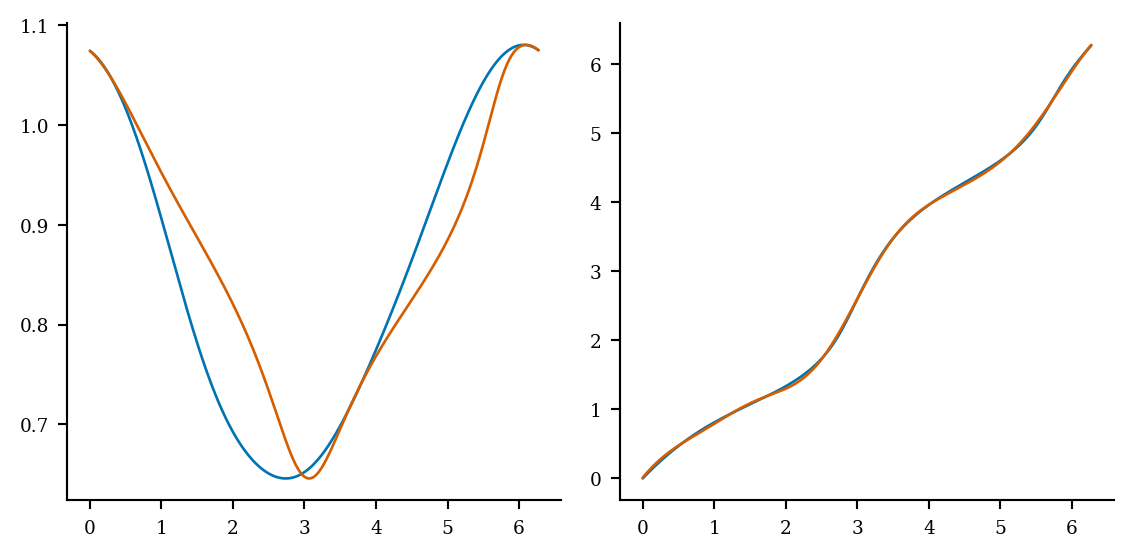

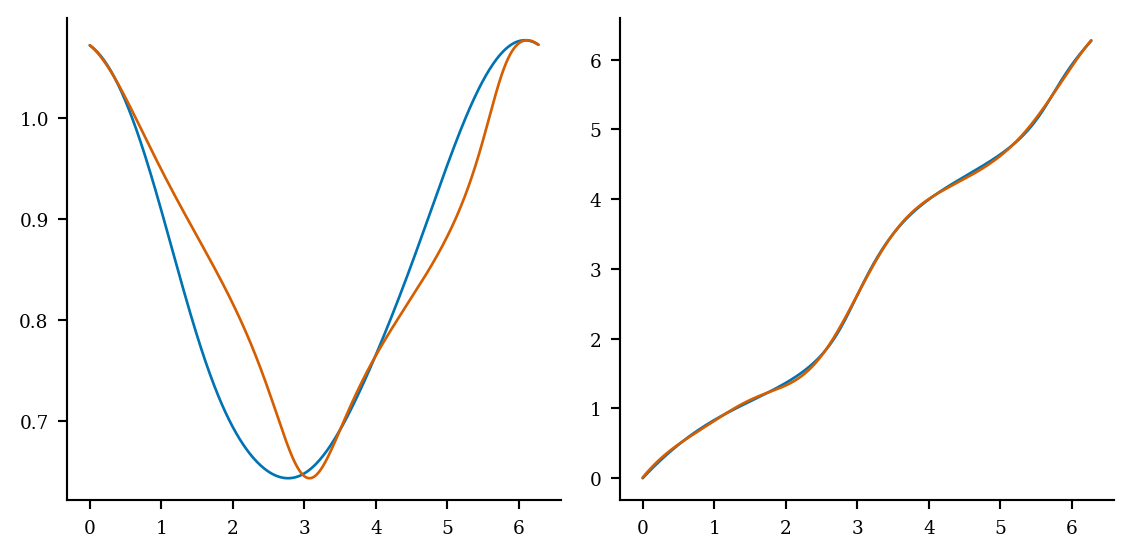

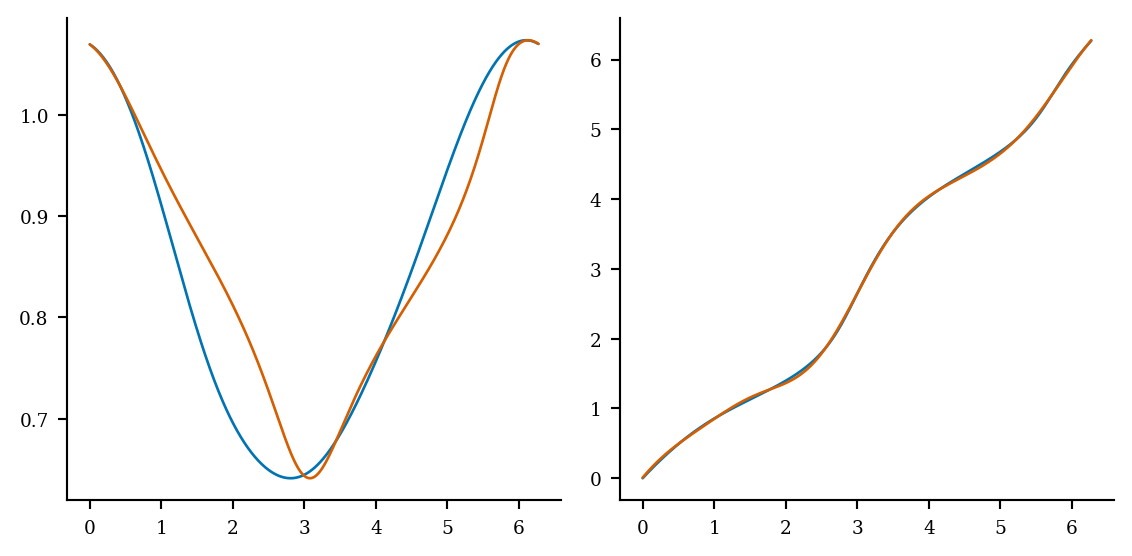

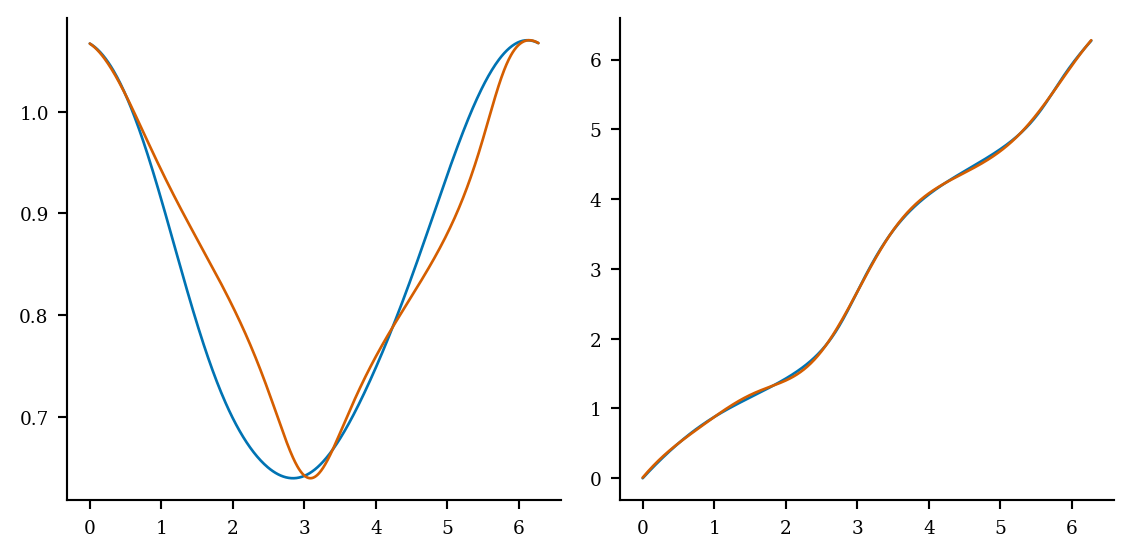

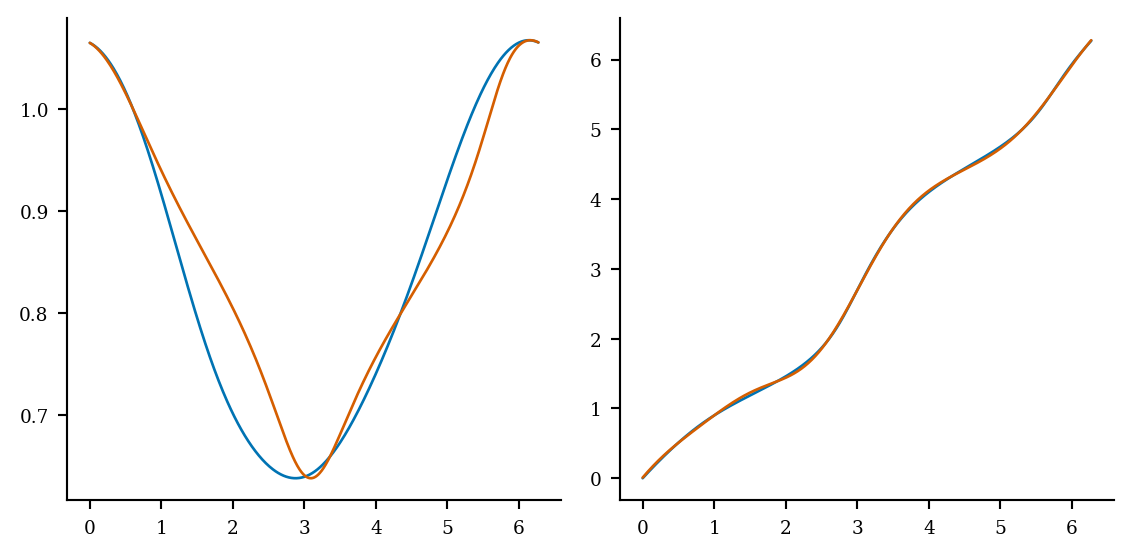

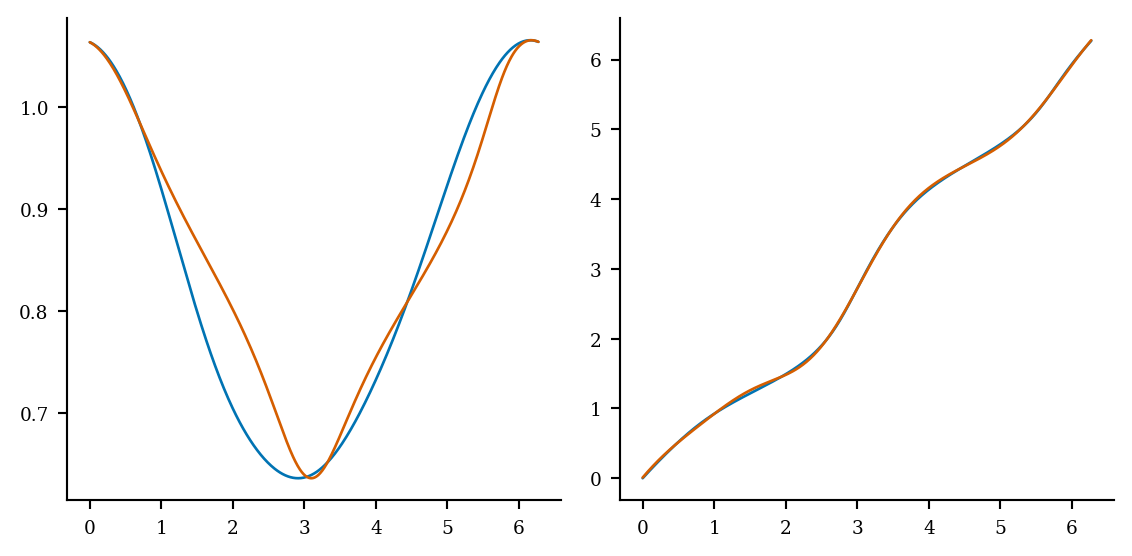

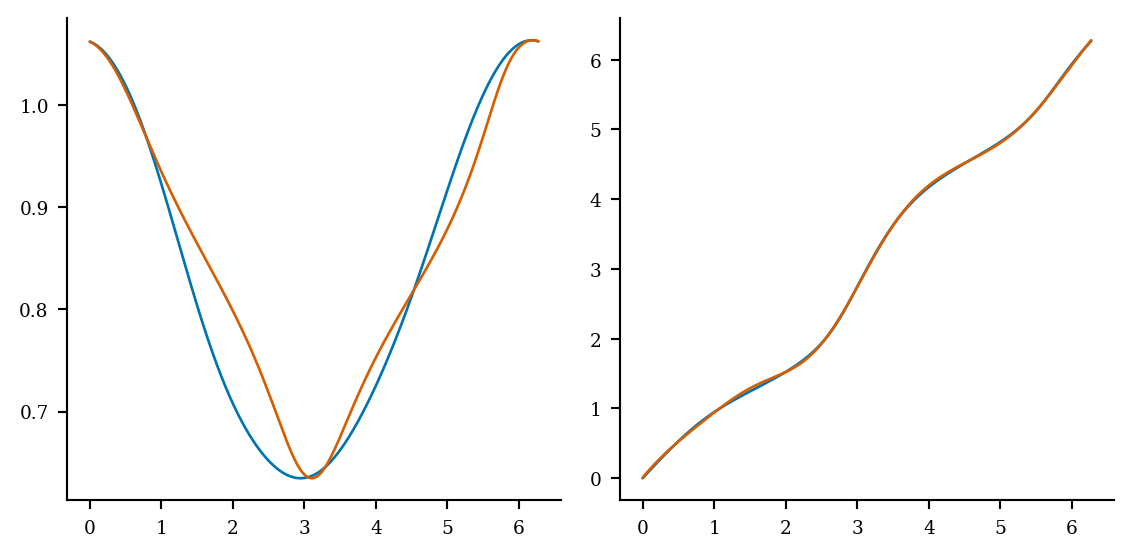

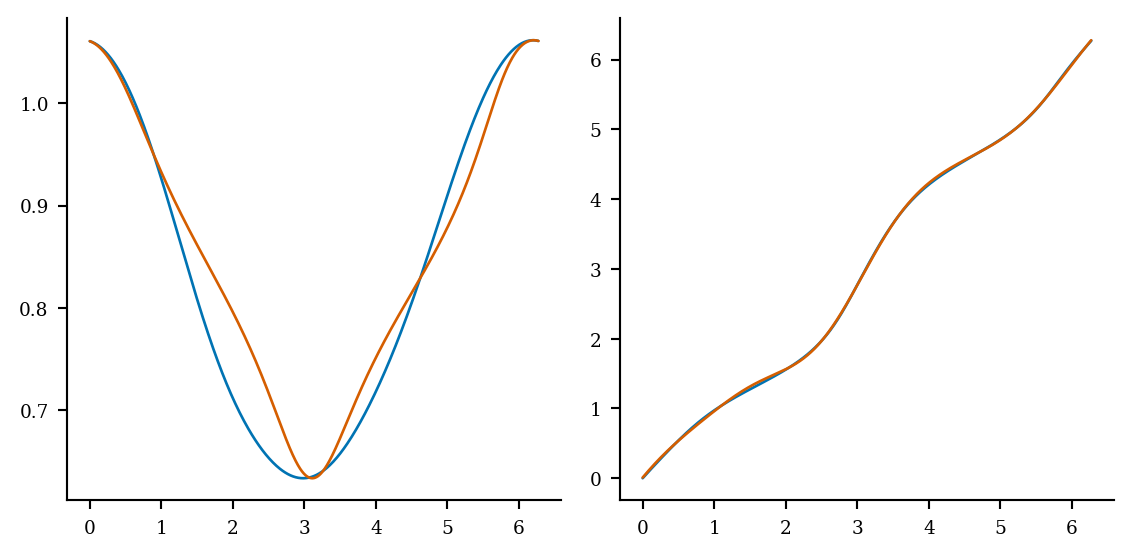

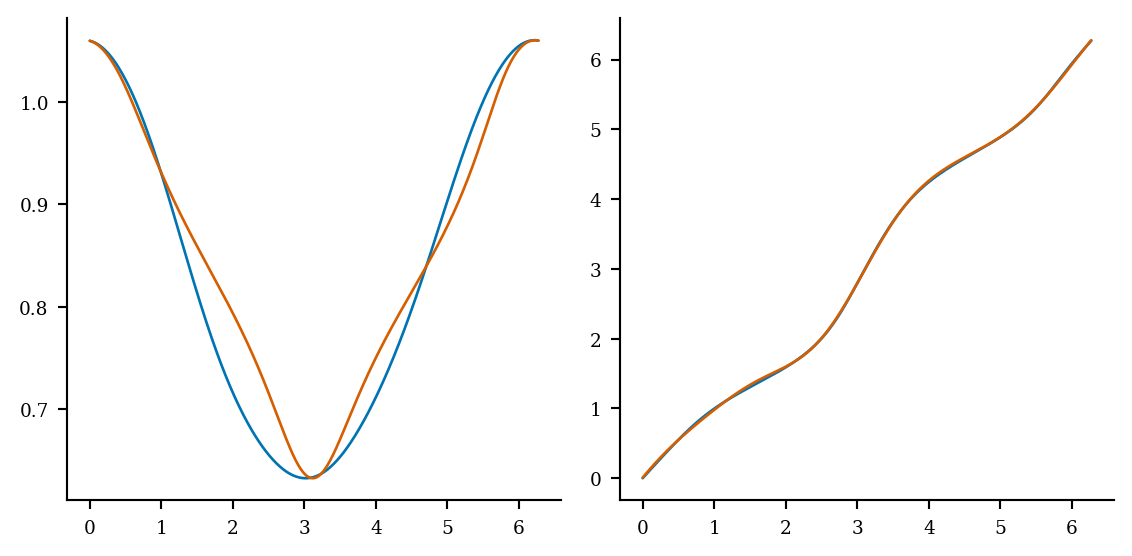

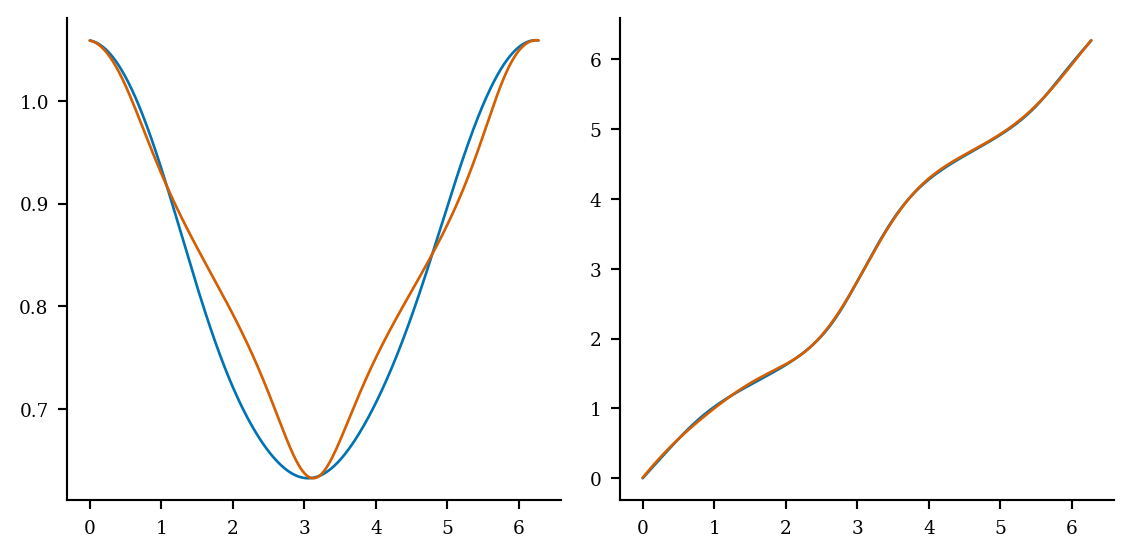

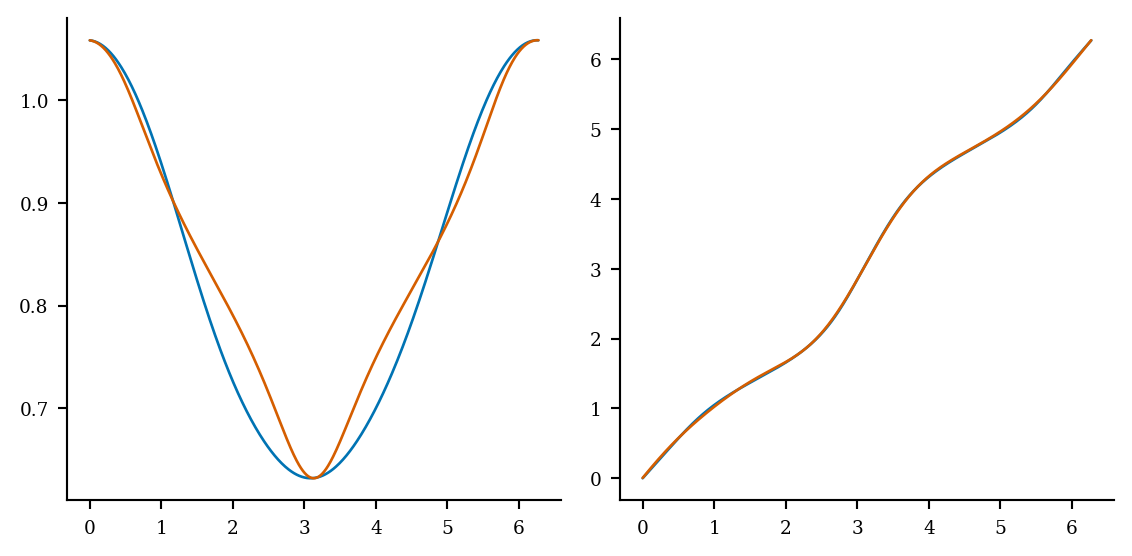

In [19]:
import desc.examples
from desc.plotting import plot_3d, plot_boundary
from desc.grid import LinearGrid, Grid
from desc.basis import DoubleFourierSeries, ChebyshevPolynomial, PowerSeries, FourierSeries
from desc.transform import Transform
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

eq = desc.examples.get("precise_QA")
surface = eq.surface
axis = eq.get_axis()

M=256
N=64

grid = LinearGrid(M=M, N=N, NFP=2)

surface_data = surface.compute(["R", "Z"], grid=grid)
surface_data = np.c_[surface_data["R"], surface_data["Z"]]

axis_data = axis.compute(["R", "Z"], grid=grid)
axis_data = np.c_[axis_data["R"], axis_data["Z"]]

minor_vectors = surface_data - axis_data
# theta = (np.arctan2(minor_vectors[:,1], -minor_vectors[:,0]) + np.pi) % (2.0 * np.pi)
theta = np.arctan2(minor_vectors[:,1], -minor_vectors[:,0]) + np.pi
tmp_theta_start = theta[::M*2+1].copy()
tmp_theta_start[tmp_theta_start>np.pi] -= 2.0*np.pi
theta -= tmp_theta_start.repeat(M*2+1)
theta = theta % (2.0 * np.pi)
# theta += tmp_theta_start

sample_points = grid.nodes.reshape(N*2+1, M*2+1, 3)

theta_start_basis = FourierSeries(N=4, NFP=2, sym='sin')
theta_start_transform = Transform(
    LinearGrid(
        N=N, 
        NFP=2,
    ), 
    theta_start_basis, 
    build=False, 
    build_pinv=True
)
Ts_n = theta_start_transform.fit(tmp_theta_start)


theta_basis = DoubleFourierSeries(M=4, N=8, NFP=2, sym='sin')
theta_transform = Transform(
    Grid(
        np.c_[np.ones_like(theta), theta, grid.nodes[:,2]], 
        sort=False, 
        jitable=True
    ), 
    theta_basis, 
    build=False, 
    build_pinv=True
)
Tb_lmn = theta_transform.fit(grid.nodes[:,1] - theta)

transformed_theta = Transform(
    grid, 
    theta_basis, 
    build=True,
).transform(Tb_lmn, 0, 0, 0)

for i in range(N):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    s = i * (M*2+1)
    e = (i+1) * (M*2+1)
    ax1.plot(sample_points[i,:,1], surface_data[s:e,0])
    ax1.plot(theta[s:e], surface_data[s:e,0])
    ax2.plot(theta[s:e], sample_points[i,:,1])
    ax2.plot(sample_points[i,:,1], transformed_theta[s:e] + sample_points[i,:,1])
    plt.show()

In [93]:
for m, c in zip(theta_basis.modes, Tb_lmn):
    print(m, c)

[ 0  0 -8] -0.010595392603088056
[ 0  1 -8] 0.008805592846374537
[ 0  2 -8] 0.02214052160576823
[ 0  3 -8] -0.02502028287365168
[ 0  4 -8] -0.014409932884261956
[ 0  0 -7] -0.01291431395566557
[ 0  1 -7] 0.010427936132103964
[ 0  2 -7] 0.031663441077384176
[ 0  3 -7] -0.044576669314793094
[ 0  4 -7] -0.02374472344620071
[ 0  0 -6] -0.015450866181378708
[ 0  1 -6] 0.010755594397433916
[ 0  2 -6] 0.04478867229897964
[ 0  3 -6] -0.06652509771830462
[ 0  4 -6] -0.032942623486484905
[ 0  0 -5] -0.0225055881755856
[ 0  1 -5] 0.012791388160219614
[ 0  2 -5] 0.06706091807907458
[ 0  3 -5] -0.09400257903819917
[ 0  4 -5] -0.04262041389714202
[ 0  0 -4] -0.03985903939017489
[ 0  1 -4] 0.020507480195005298
[ 0  2 -4] 0.10536365896133977
[ 0  3 -4] -0.12630068342661943
[ 0  4 -4] -0.053914903849172933
[ 0  0 -3] -0.07912473188107762
[ 0  1 -3] 0.03911136594720294
[ 0  2 -3] 0.1590861114559701
[ 0  3 -3] -0.14600294180437098
[ 0  4 -3] -0.04866989409586371
[ 0  0 -2] -0.2040812388840856
[ 0  1 -2] 

In [20]:
Ts_n

Array([-0.03721455, -0.08002005, -0.18206658, -0.42863913], dtype=float64)

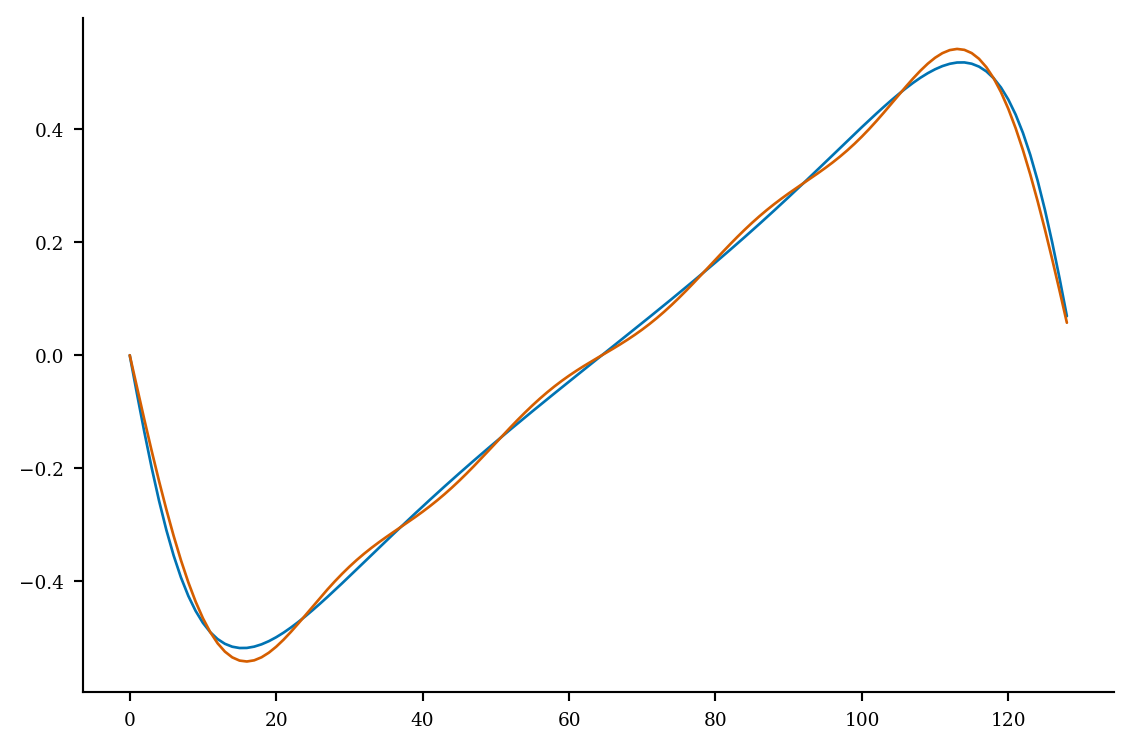

In [16]:
tmp_theta_start[tmp_theta_start>np.pi] -= 2.0*np.pi
plt.plot(tmp_theta_start)
transformed_theta_start = Transform(
    LinearGrid(
        N=N, 
        NFP=2
    ), 
    theta_start_basis, 
    build=True,
).transform(Ts_n, 0, 0, 0)
plt.plot(transformed_theta_start)

In [21]:
for m, c in zip(surface.R_basis.modes, surface.R_lmn):
    print(m, c)

[ 0 -8 -8] -2.0740599232993023e-09
[ 0 -7 -8] -4.682805575853149e-10
[ 0 -6 -8] -1.881981674093158e-09
[ 0 -5 -8] 1.1578145663302794e-11
[ 0 -4 -8] 5.984480200212767e-10
[ 0 -3 -8] 7.62538566700838e-10
[ 0 -2 -8] -3.347918940984995e-10
[ 0 -1 -8] 2.091540852315281e-09
[ 0 -8 -7] -9.691652817538962e-09
[ 0 -7 -7] 3.137488883590532e-07
[ 0 -6 -7] 1.3965642784785618e-08
[ 0 -5 -7] 1.0629105235627623e-07
[ 0 -4 -7] -1.029608483692375e-09
[ 0 -3 -7] -4.026292395259625e-08
[ 0 -2 -7] -5.122074956937111e-09
[ 0 -1 -7] -2.3557716984704852e-08
[ 0 -8 -6] -7.674048618064794e-09
[ 0 -7 -6] 4.129830119648322e-07
[ 0 -6 -6] -4.509577861678662e-08
[ 0 -5 -6] -1.0569691922412212e-07
[ 0 -4 -6] 2.319561441255777e-07
[ 0 -3 -6] 7.040225916467776e-08
[ 0 -2 -6] -1.0849247496106808e-07
[ 0 -1 -6] 1.2478342859484978e-07
[ 0 -8 -5] 2.7190231956315924e-09
[ 0 -7 -5] -1.619378717884307e-07
[ 0 -6 -5] -9.844154247450484e-07
[ 0 -5 -5] 2.514409008276808e-06
[ 0 -4 -5] 4.7185983444582856e-07
[ 0 -3 -5] -1.83787

In [26]:
i = 0
j = 0
surface.R_lmn[np.where(np.all(np.c_[surface.R_basis.modes[:,1] == j+1, surface.R_basis.modes[:,2] == i+1], axis=1))[0][0]]

np.float64(-0.07444245337161019)

In [ ]:
for i in [-5, -6, -7, -8]: # n
    for j in [0]: # m
        print(surface.Z_lmn[np.where(np.all(np.c_[surface.Z_basis.modes[:,1] == j, surface.Z_basis.modes[:,2] == i], axis=1))[0][0]], end='')
        print(", ", end='')
    print()

6.013807919962239e-07, -1.3683319532788955e-09, -1.6869223918688115e-08, 7.657206740036527e-10, 

In [36]:
surface.Z_basis.modes

array([[ 0,  0, -8],
       [ 0,  1, -8],
       [ 0,  2, -8],
       [ 0,  3, -8],
       [ 0,  4, -8],
       [ 0,  5, -8],
       [ 0,  6, -8],
       [ 0,  7, -8],
       [ 0,  8, -8],
       [ 0,  0, -7],
       [ 0,  1, -7],
       [ 0,  2, -7],
       [ 0,  3, -7],
       [ 0,  4, -7],
       [ 0,  5, -7],
       [ 0,  6, -7],
       [ 0,  7, -7],
       [ 0,  8, -7],
       [ 0,  0, -6],
       [ 0,  1, -6],
       [ 0,  2, -6],
       [ 0,  3, -6],
       [ 0,  4, -6],
       [ 0,  5, -6],
       [ 0,  6, -6],
       [ 0,  7, -6],
       [ 0,  8, -6],
       [ 0,  0, -5],
       [ 0,  1, -5],
       [ 0,  2, -5],
       [ 0,  3, -5],
       [ 0,  4, -5],
       [ 0,  5, -5],
       [ 0,  6, -5],
       [ 0,  7, -5],
       [ 0,  8, -5],
       [ 0,  0, -4],
       [ 0,  1, -4],
       [ 0,  2, -4],
       [ 0,  3, -4],
       [ 0,  4, -4],
       [ 0,  5, -4],
       [ 0,  6, -4],
       [ 0,  7, -4],
       [ 0,  8, -4],
       [ 0,  0, -3],
       [ 0,  1, -3],
       [ 0,  